In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [3]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [10]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

loss.py

In [11]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [12]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [13]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [14]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [15]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [16]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [17]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [18]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [19]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [20]:

from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
        ''' 
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
                                                 shuffle=False, num_workers = 8)
        
        '''
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
    

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1
    '''
        
    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state= loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [21]:


from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)


            
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [22]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
 
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [23]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            

    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        
        
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
        '''
        
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        '''

        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)
    '''
    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1 
    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [24]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [25]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [26]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [27]:

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [28]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [29]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)


net.py

In [30]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    
    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    
    torch.backends.cudnn.benchmark = True
    return model   
    


def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [31]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [32]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")

def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes=len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch, cidx] = t.mean(curr_state[pos]).numpy()

    # Transpose the matrix before plotting
    transposed_maps = np.transpose(maps)

    sns.heatmap(transposed_maps, cmap='YlGnBu', vmin=0, vmax=10)
    plt.xlabel('Epoch')
    plt.ylabel('Class index')

    # Flip the graph vertically before saving
    plt.gca().invert_yaxis()

    os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    plt.savefig(f'{out}/score_epoch_plot/{name}.png')

    plt.close()

    return maps


In [34]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [35]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=False, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ce_drw', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            class_params = {
            'linear.weight': model_weights['linear.weight'][class_label],
            'linear.bias': model_weights['linear.bias'][class_label]
            }
            class_l1_norm = sum(torch.abs(param).sum() for param in class_params.values())
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()
    
    


---> ---cifar100---
---> Argument
    > network     : resnet32
    > epochs      : 200
    > batch_size  : 128
    > update_epoch: 1
    > lr          : 0.1
    > lr_decay    : 0.01
    > momentum    : 0.9
    > wd          : 0.0002
    > nesterov    : False
    > scheduler   : warmup
    > warmup      : 5
    > aug_prob    : 0.5
    > cutout      : False
    > cmo         : False
    > posthoc_la  : False
    > cuda        : False
    > aug_type    : none
    > sim_type    : none
    > max_d       : 30
    > num_test    : 10
    > accept_rate : 0.6
    > verbose     : False
    > use_norm    : False
    > out         : /kaggle/working/log3
    > data_dir    : ~/dataset/
    > workers     : 4
    > seed        : None
    > gpu         : 0
    > dataset     : cifar100
    > num_max     : 500
    > imb_ratio   : 100
    > loss_fn     : ce_drw
    > num_experts : 3
    > ride_distill: False
    > num_class   : 100


==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


---> Epoch: [1 | 200]
    > [Train]	Loss:	4.0733
    > [Test ]	Loss:	5.3344	Acc:	4.5600
    > [Stats]	Many:	0.1277	Medium:	0.0026	Few:	0.0000
    > [Best ]	Acc:	4.5600	Many:	12.7714	Medium:	0.2571	Few:	0.0000
    > [Param]	LR:	0.02000000


0.7331374223447409


---> Epoch: [2 | 200]
    > [Train]	Loss:	3.6156
    > [Test ]	Loss:	5.0759	Acc:	6.1900
    > [Stats]	Many:	0.1769	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	6.1900	Many:	17.6857	Medium:	0.0000	Few:	0.0000
    > [Param]	LR:	0.04000000


0.7003908520922258


---> Epoch: [3 | 200]
    > [Train]	Loss:	3.4034
    > [Test ]	Loss:	4.8982	Acc:	7.3000
    > [Stats]	Many:	0.1809	Medium:	0.0277	Few:	0.0000
    > [Best ]	Acc:	7.3000	Many:	18.0857	Medium:	2.7714	Few:	0.0000
    > [Param]	LR:	0.06000000


0.7489827843103728


---> Epoch: [4 | 200]
    > [Train]	Loss:	3.2129
    > [Test ]	Loss:	4.9275	Acc:	7.5700
    > [Stats]	Many:	0.2091	Medium:	0.0071	Few:	0.0000
    > [Best ]	Acc:	7.5700	Many:	20.9143	Medium:	0.7143	Few:	0.0000
    > [Param]	LR:	0.08000000


0.9013158511162322


---> Epoch: [5 | 200]
    > [Train]	Loss:	3.0865
    > [Test ]	Loss:	4.8473	Acc:	9.5300
    > [Stats]	Many:	0.2389	Medium:	0.0334	Few:	0.0000
    > [Best ]	Acc:	9.5300	Many:	23.8857	Medium:	3.3429	Few:	0.0000
    > [Param]	LR:	0.10000000


1.1403339757960271


---> Epoch: [6 | 200]
    > [Train]	Loss:	2.9053
    > [Test ]	Loss:	4.9509	Acc:	10.9900
    > [Stats]	Many:	0.2806	Medium:	0.0334	Few:	0.0000
    > [Best ]	Acc:	10.9900	Many:	28.0571	Medium:	3.3429	Few:	0.0000
    > [Param]	LR:	0.10000000


1.3796312073260708


---> Epoch: [7 | 200]
    > [Train]	Loss:	2.7221
    > [Test ]	Loss:	4.7897	Acc:	12.1200
    > [Stats]	Many:	0.2803	Medium:	0.0660	Few:	0.0000
    > [Best ]	Acc:	12.1200	Many:	28.0286	Medium:	6.6000	Few:	0.0000
    > [Param]	LR:	0.10000000


1.6077951436317115


---> Epoch: [8 | 200]
    > [Train]	Loss:	2.6129
    > [Test ]	Loss:	4.7789	Acc:	12.4500
    > [Stats]	Many:	0.2889	Medium:	0.0669	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	28.8857	Medium:	6.6857	Few:	0.0000
    > [Param]	LR:	0.10000000


1.80477040966406


---> Epoch: [9 | 200]
    > [Train]	Loss:	2.4719
    > [Test ]	Loss:	4.6223	Acc:	13.9100
    > [Stats]	Many:	0.3406	Medium:	0.0566	Few:	0.0003
    > [Best ]	Acc:	13.9100	Many:	34.0571	Medium:	5.6571	Few:	0.0333
    > [Param]	LR:	0.10000000


1.9695476276344863


---> Epoch: [10 | 200]
    > [Train]	Loss:	2.3918
    > [Test ]	Loss:	4.3493	Acc:	15.7400
    > [Stats]	Many:	0.3597	Medium:	0.0886	Few:	0.0017
    > [Best ]	Acc:	15.7400	Many:	35.9714	Medium:	8.8571	Few:	0.1667
    > [Param]	LR:	0.10000000


2.1227972024028774


---> Epoch: [11 | 200]
    > [Train]	Loss:	2.2673
    > [Test ]	Loss:	4.3498	Acc:	16.7300
    > [Stats]	Many:	0.3740	Medium:	0.1040	Few:	0.0000
    > [Best ]	Acc:	16.7300	Many:	37.4000	Medium:	10.4000	Few:	0.0000
    > [Param]	LR:	0.10000000


2.269442113367792


---> Epoch: [12 | 200]
    > [Train]	Loss:	2.1767
    > [Test ]	Loss:	4.2915	Acc:	17.5200
    > [Stats]	Many:	0.3877	Medium:	0.1126	Few:	0.0003
    > [Best ]	Acc:	17.5200	Many:	38.7714	Medium:	11.2571	Few:	0.0333
    > [Param]	LR:	0.10000000


2.403048489284309


---> Epoch: [13 | 200]
    > [Train]	Loss:	2.0678
    > [Test ]	Loss:	4.1130	Acc:	19.0700
    > [Stats]	Many:	0.4026	Medium:	0.1389	Few:	0.0040
    > [Best ]	Acc:	19.0700	Many:	40.2571	Medium:	13.8857	Few:	0.4000
    > [Param]	LR:	0.10000000


2.539726160013663


---> Epoch: [14 | 200]
    > [Train]	Loss:	2.0081
    > [Test ]	Loss:	4.1395	Acc:	19.2300
    > [Stats]	Many:	0.4249	Medium:	0.1200	Few:	0.0053
    > [Best ]	Acc:	19.2300	Many:	42.4857	Medium:	12.0000	Few:	0.5333
    > [Param]	LR:	0.10000000


2.6517016425803193


---> Epoch: [15 | 200]
    > [Train]	Loss:	1.9326
    > [Test ]	Loss:	3.9846	Acc:	21.4200
    > [Stats]	Many:	0.4483	Medium:	0.1574	Few:	0.0073
    > [Best ]	Acc:	21.4200	Many:	44.8286	Medium:	15.7429	Few:	0.7333
    > [Param]	LR:	0.10000000


2.750523021513866


---> Epoch: [16 | 200]
    > [Train]	Loss:	1.8538
    > [Test ]	Loss:	4.1863	Acc:	20.8500
    > [Stats]	Many:	0.4591	Medium:	0.1334	Few:	0.0037
    > [Best ]	Acc:	21.4200	Many:	44.8286	Medium:	15.7429	Few:	0.7333
    > [Param]	LR:	0.10000000


2.840059118801284


---> Epoch: [17 | 200]
    > [Train]	Loss:	1.7739
    > [Test ]	Loss:	4.1406	Acc:	22.0300
    > [Stats]	Many:	0.4771	Medium:	0.1463	Few:	0.0070
    > [Best ]	Acc:	22.0300	Many:	47.7143	Medium:	14.6286	Few:	0.7000
    > [Param]	LR:	0.10000000


2.927864755812453


---> Epoch: [18 | 200]
    > [Train]	Loss:	1.7169
    > [Test ]	Loss:	3.9821	Acc:	23.1800
    > [Stats]	Many:	0.4766	Medium:	0.1820	Few:	0.0043
    > [Best ]	Acc:	23.1800	Many:	47.6571	Medium:	18.2000	Few:	0.4333
    > [Param]	LR:	0.10000000


2.97029454427814


---> Epoch: [19 | 200]
    > [Train]	Loss:	1.6674
    > [Test ]	Loss:	3.8134	Acc:	23.6900
    > [Stats]	Many:	0.4746	Medium:	0.1963	Few:	0.0070
    > [Best ]	Acc:	23.6900	Many:	47.4571	Medium:	19.6286	Few:	0.7000
    > [Param]	LR:	0.10000000


3.0375377892522457


---> Epoch: [20 | 200]
    > [Train]	Loss:	1.6145
    > [Test ]	Loss:	3.7205	Acc:	24.6700
    > [Stats]	Many:	0.5237	Medium:	0.1677	Few:	0.0157
    > [Best ]	Acc:	24.6700	Many:	52.3714	Medium:	16.7714	Few:	1.5667
    > [Param]	LR:	0.10000000


3.082997394729207


---> Epoch: [21 | 200]
    > [Train]	Loss:	1.5692
    > [Test ]	Loss:	3.7506	Acc:	24.1300
    > [Stats]	Many:	0.4891	Medium:	0.1923	Few:	0.0093
    > [Best ]	Acc:	24.6700	Many:	52.3714	Medium:	16.7714	Few:	1.5667
    > [Param]	LR:	0.10000000


3.173181643170272


---> Epoch: [22 | 200]
    > [Train]	Loss:	1.5275
    > [Test ]	Loss:	3.7765	Acc:	22.8200
    > [Stats]	Many:	0.4866	Medium:	0.1634	Few:	0.0023
    > [Best ]	Acc:	24.6700	Many:	52.3714	Medium:	16.7714	Few:	1.5667
    > [Param]	LR:	0.10000000


3.1861574976378093


---> Epoch: [23 | 200]
    > [Train]	Loss:	1.4752
    > [Test ]	Loss:	3.4981	Acc:	27.9900
    > [Stats]	Many:	0.5403	Medium:	0.2471	Few:	0.0143
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.2328157438928966


---> Epoch: [24 | 200]
    > [Train]	Loss:	1.4331
    > [Test ]	Loss:	4.3408	Acc:	23.1400
    > [Stats]	Many:	0.4731	Medium:	0.1817	Few:	0.0073
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.2689806915248347


---> Epoch: [25 | 200]
    > [Train]	Loss:	1.3893
    > [Test ]	Loss:	4.1946	Acc:	23.2500
    > [Stats]	Many:	0.4694	Medium:	0.1857	Few:	0.0107
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.3048579210949196


---> Epoch: [26 | 200]
    > [Train]	Loss:	1.3641
    > [Test ]	Loss:	3.7874	Acc:	25.9600
    > [Stats]	Many:	0.5420	Medium:	0.1911	Few:	0.0100
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.349235640899656


---> Epoch: [27 | 200]
    > [Train]	Loss:	1.3285
    > [Test ]	Loss:	4.2672	Acc:	22.4000
    > [Stats]	Many:	0.4577	Medium:	0.1711	Few:	0.0130
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.3496990768568113


---> Epoch: [28 | 200]
    > [Train]	Loss:	1.2928
    > [Test ]	Loss:	3.7995	Acc:	25.7400
    > [Stats]	Many:	0.5214	Medium:	0.2026	Few:	0.0133
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.349386087902296


---> Epoch: [29 | 200]
    > [Train]	Loss:	1.2535
    > [Test ]	Loss:	3.7432	Acc:	26.0600
    > [Stats]	Many:	0.5266	Medium:	0.2020	Few:	0.0187
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.395568698454504


---> Epoch: [30 | 200]
    > [Train]	Loss:	1.2396
    > [Test ]	Loss:	3.8736	Acc:	26.5500
    > [Stats]	Many:	0.4994	Medium:	0.2440	Few:	0.0177
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.3892482599641003


---> Epoch: [31 | 200]
    > [Train]	Loss:	1.1999
    > [Test ]	Loss:	3.8255	Acc:	27.6600
    > [Stats]	Many:	0.5449	Medium:	0.2343	Few:	0.0130
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.4266375015131


---> Epoch: [32 | 200]
    > [Train]	Loss:	1.1508
    > [Test ]	Loss:	3.8985	Acc:	25.6600
    > [Stats]	Many:	0.5229	Medium:	0.1926	Few:	0.0207
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.4456498790323216


---> Epoch: [33 | 200]
    > [Train]	Loss:	1.1432
    > [Test ]	Loss:	3.9496	Acc:	24.7800
    > [Stats]	Many:	0.4829	Medium:	0.2003	Few:	0.0290
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.450965605966762


---> Epoch: [34 | 200]
    > [Train]	Loss:	1.1133
    > [Test ]	Loss:	4.0842	Acc:	24.0600
    > [Stats]	Many:	0.4571	Medium:	0.2131	Few:	0.0200
    > [Best ]	Acc:	27.9900	Many:	54.0286	Medium:	24.7143	Few:	1.4333
    > [Param]	LR:	0.10000000


3.4375864623414114


---> Epoch: [35 | 200]
    > [Train]	Loss:	1.0742
    > [Test ]	Loss:	3.7957	Acc:	28.6400
    > [Stats]	Many:	0.5723	Medium:	0.2200	Few:	0.0303
    > [Best ]	Acc:	28.6400	Many:	57.2286	Medium:	22.0000	Few:	3.0333
    > [Param]	LR:	0.10000000


3.4532537476330276


---> Epoch: [36 | 200]
    > [Train]	Loss:	1.0458
    > [Test ]	Loss:	4.0145	Acc:	26.5200
    > [Stats]	Many:	0.5066	Medium:	0.2174	Few:	0.0393
    > [Best ]	Acc:	28.6400	Many:	57.2286	Medium:	22.0000	Few:	3.0333
    > [Param]	LR:	0.10000000


3.468006087144156


---> Epoch: [37 | 200]
    > [Train]	Loss:	1.0287
    > [Test ]	Loss:	3.9441	Acc:	29.2600
    > [Stats]	Many:	0.5243	Medium:	0.2837	Few:	0.0327
    > [Best ]	Acc:	29.2600	Many:	52.4286	Medium:	28.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


3.471700195499056


---> Epoch: [38 | 200]
    > [Train]	Loss:	1.0078
    > [Test ]	Loss:	4.1798	Acc:	26.3700
    > [Stats]	Many:	0.4920	Medium:	0.2469	Few:	0.0170
    > [Best ]	Acc:	29.2600	Many:	52.4286	Medium:	28.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


3.459409682354228


---> Epoch: [39 | 200]
    > [Train]	Loss:	0.9957
    > [Test ]	Loss:	3.8568	Acc:	29.7400
    > [Stats]	Many:	0.5537	Medium:	0.2749	Few:	0.0247
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.4668156923634523


---> Epoch: [40 | 200]
    > [Train]	Loss:	0.9746
    > [Test ]	Loss:	4.0782	Acc:	27.4000
    > [Stats]	Many:	0.5263	Medium:	0.2414	Few:	0.0177
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.46541493227795


---> Epoch: [41 | 200]
    > [Train]	Loss:	0.9443
    > [Test ]	Loss:	3.7748	Acc:	28.7400
    > [Stats]	Many:	0.5294	Medium:	0.2740	Few:	0.0207
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.4479275083059155


---> Epoch: [42 | 200]
    > [Train]	Loss:	0.9347
    > [Test ]	Loss:	3.9864	Acc:	28.0000
    > [Stats]	Many:	0.5257	Medium:	0.2574	Few:	0.0197
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.4559323557440456


---> Epoch: [43 | 200]
    > [Train]	Loss:	0.8849
    > [Test ]	Loss:	4.2102	Acc:	27.9000
    > [Stats]	Many:	0.5266	Medium:	0.2497	Few:	0.0243
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.457705092999078


---> Epoch: [44 | 200]
    > [Train]	Loss:	0.8921
    > [Test ]	Loss:	4.5193	Acc:	25.5500
    > [Stats]	Many:	0.5111	Medium:	0.1809	Few:	0.0443
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.4694953813156033


---> Epoch: [45 | 200]
    > [Train]	Loss:	0.8460
    > [Test ]	Loss:	3.8919	Acc:	28.6100
    > [Stats]	Many:	0.5157	Medium:	0.2803	Few:	0.0250
    > [Best ]	Acc:	29.7400	Many:	55.3714	Medium:	27.4857	Few:	2.4667
    > [Param]	LR:	0.10000000


3.4772580643561106


---> Epoch: [46 | 200]
    > [Train]	Loss:	0.8522
    > [Test ]	Loss:	3.8392	Acc:	30.5200
    > [Stats]	Many:	0.5749	Medium:	0.2646	Few:	0.0380
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.48590400274559


---> Epoch: [47 | 200]
    > [Train]	Loss:	0.8404
    > [Test ]	Loss:	3.9367	Acc:	29.0100
    > [Stats]	Many:	0.5383	Medium:	0.2706	Few:	0.0233
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.4614739061588167


---> Epoch: [48 | 200]
    > [Train]	Loss:	0.8175
    > [Test ]	Loss:	4.1885	Acc:	25.3600
    > [Stats]	Many:	0.4823	Medium:	0.2220	Few:	0.0237
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.478549772333962


---> Epoch: [49 | 200]
    > [Train]	Loss:	0.8145
    > [Test ]	Loss:	4.1608	Acc:	27.6700
    > [Stats]	Many:	0.5154	Medium:	0.2283	Few:	0.0547
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.45595961891406


---> Epoch: [50 | 200]
    > [Train]	Loss:	0.8106
    > [Test ]	Loss:	4.1347	Acc:	27.5700
    > [Stats]	Many:	0.5106	Medium:	0.2491	Few:	0.0327
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.433351806562258


---> Epoch: [51 | 200]
    > [Train]	Loss:	0.7815
    > [Test ]	Loss:	4.5749	Acc:	28.2400
    > [Stats]	Many:	0.5294	Medium:	0.2563	Few:	0.0247
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.4155117117318623


---> Epoch: [52 | 200]
    > [Train]	Loss:	0.7520
    > [Test ]	Loss:	4.4244	Acc:	26.6900
    > [Stats]	Many:	0.5094	Medium:	0.2217	Few:	0.0367
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.4057478447422604


---> Epoch: [53 | 200]
    > [Train]	Loss:	0.7177
    > [Test ]	Loss:	4.4990	Acc:	28.1100
    > [Stats]	Many:	0.5274	Medium:	0.2617	Few:	0.0163
    > [Best ]	Acc:	30.5200	Many:	57.4857	Medium:	26.4571	Few:	3.8000
    > [Param]	LR:	0.10000000


3.4273988726865863


---> Epoch: [54 | 200]
    > [Train]	Loss:	0.7283
    > [Test ]	Loss:	3.9636	Acc:	31.6100
    > [Stats]	Many:	0.5443	Medium:	0.3180	Few:	0.0477
    > [Best ]	Acc:	31.6100	Many:	54.4286	Medium:	31.8000	Few:	4.7667
    > [Param]	LR:	0.10000000


3.4422859579699137


---> Epoch: [55 | 200]
    > [Train]	Loss:	0.7105
    > [Test ]	Loss:	3.7311	Acc:	32.0000
    > [Stats]	Many:	0.5594	Medium:	0.3006	Few:	0.0633
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.4209067762516114


---> Epoch: [56 | 200]
    > [Train]	Loss:	0.6922
    > [Test ]	Loss:	4.2551	Acc:	28.8100
    > [Stats]	Many:	0.5231	Medium:	0.2634	Few:	0.0427
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.428240577547114


---> Epoch: [57 | 200]
    > [Train]	Loss:	0.7032
    > [Test ]	Loss:	3.9665	Acc:	31.2900
    > [Stats]	Many:	0.5794	Medium:	0.2831	Few:	0.0367
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.399829782439651


---> Epoch: [58 | 200]
    > [Train]	Loss:	0.6725
    > [Test ]	Loss:	4.3042	Acc:	29.4500
    > [Stats]	Many:	0.5614	Medium:	0.2531	Few:	0.0313
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.418026874946907


---> Epoch: [59 | 200]
    > [Train]	Loss:	0.6825
    > [Test ]	Loss:	4.5333	Acc:	28.0600
    > [Stats]	Many:	0.5146	Medium:	0.2597	Few:	0.0320
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.4215663262883216


---> Epoch: [60 | 200]
    > [Train]	Loss:	0.6744
    > [Test ]	Loss:	3.9702	Acc:	30.5800
    > [Stats]	Many:	0.5123	Medium:	0.3029	Few:	0.0683
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.391786887236237


---> Epoch: [61 | 200]
    > [Train]	Loss:	0.6374
    > [Test ]	Loss:	4.3446	Acc:	29.2500
    > [Stats]	Many:	0.5771	Medium:	0.2171	Few:	0.0483
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.407941558669105


---> Epoch: [62 | 200]
    > [Train]	Loss:	0.6395
    > [Test ]	Loss:	4.4163	Acc:	27.6500
    > [Stats]	Many:	0.5180	Medium:	0.2411	Few:	0.0360
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.4003226275936496


---> Epoch: [63 | 200]
    > [Train]	Loss:	0.6405
    > [Test ]	Loss:	3.8769	Acc:	31.4700
    > [Stats]	Many:	0.5377	Medium:	0.2963	Few:	0.0760
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3876452089761244


---> Epoch: [64 | 200]
    > [Train]	Loss:	0.6197
    > [Test ]	Loss:	4.2943	Acc:	29.6600
    > [Stats]	Many:	0.5286	Medium:	0.2823	Few:	0.0427
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3972029996637922


---> Epoch: [65 | 200]
    > [Train]	Loss:	0.6106
    > [Test ]	Loss:	4.0314	Acc:	30.8700
    > [Stats]	Many:	0.5251	Medium:	0.3051	Few:	0.0603
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.398519062765417


---> Epoch: [66 | 200]
    > [Train]	Loss:	0.6009
    > [Test ]	Loss:	3.8423	Acc:	31.9400
    > [Stats]	Many:	0.5226	Medium:	0.3400	Few:	0.0583
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.401831830424383


---> Epoch: [67 | 200]
    > [Train]	Loss:	0.6016
    > [Test ]	Loss:	4.4947	Acc:	29.1500
    > [Stats]	Many:	0.5529	Medium:	0.2509	Few:	0.0340
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.394160656665697


---> Epoch: [68 | 200]
    > [Train]	Loss:	0.6009
    > [Test ]	Loss:	3.9890	Acc:	31.8500
    > [Stats]	Many:	0.5543	Medium:	0.3131	Few:	0.0497
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3574833938295714


---> Epoch: [69 | 200]
    > [Train]	Loss:	0.5970
    > [Test ]	Loss:	4.0572	Acc:	30.8900
    > [Stats]	Many:	0.5763	Medium:	0.2726	Few:	0.0393
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.373691610237675


---> Epoch: [70 | 200]
    > [Train]	Loss:	0.5577
    > [Test ]	Loss:	4.3515	Acc:	30.0100
    > [Stats]	Many:	0.5186	Medium:	0.3023	Few:	0.0427
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3748516733023446


---> Epoch: [71 | 200]
    > [Train]	Loss:	0.5643
    > [Test ]	Loss:	4.2809	Acc:	31.0600
    > [Stats]	Many:	0.5537	Medium:	0.2866	Few:	0.0550
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3677924593873843


---> Epoch: [72 | 200]
    > [Train]	Loss:	0.5728
    > [Test ]	Loss:	4.0220	Acc:	31.2200
    > [Stats]	Many:	0.5517	Medium:	0.2903	Few:	0.0583
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3768822721209655


---> Epoch: [73 | 200]
    > [Train]	Loss:	0.5568
    > [Test ]	Loss:	4.2954	Acc:	29.9300
    > [Stats]	Many:	0.5363	Medium:	0.2726	Few:	0.0540
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3838228536447077


---> Epoch: [74 | 200]
    > [Train]	Loss:	0.5554
    > [Test ]	Loss:	4.0634	Acc:	30.2200
    > [Stats]	Many:	0.5214	Medium:	0.2920	Few:	0.0583
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.4010870450261828


---> Epoch: [75 | 200]
    > [Train]	Loss:	0.5434
    > [Test ]	Loss:	4.1564	Acc:	31.5800
    > [Stats]	Many:	0.5617	Medium:	0.2820	Few:	0.0683
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.3991703828761133


---> Epoch: [76 | 200]
    > [Train]	Loss:	0.5276
    > [Test ]	Loss:	4.3495	Acc:	30.9300
    > [Stats]	Many:	0.5903	Medium:	0.2420	Few:	0.0600
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.4118800518295105


---> Epoch: [77 | 200]
    > [Train]	Loss:	0.5326
    > [Test ]	Loss:	5.1114	Acc:	27.6800
    > [Stats]	Many:	0.5351	Medium:	0.2071	Few:	0.0567
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.401288997502583


---> Epoch: [78 | 200]
    > [Train]	Loss:	0.5027
    > [Test ]	Loss:	4.7386	Acc:	27.9200
    > [Stats]	Many:	0.5014	Medium:	0.2514	Few:	0.0523
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.409663226406207


---> Epoch: [79 | 200]
    > [Train]	Loss:	0.5295
    > [Test ]	Loss:	4.4343	Acc:	29.8600
    > [Stats]	Many:	0.5280	Medium:	0.2949	Few:	0.0353
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.408928734862611


---> Epoch: [80 | 200]
    > [Train]	Loss:	0.5033
    > [Test ]	Loss:	4.5489	Acc:	30.0300
    > [Stats]	Many:	0.5434	Medium:	0.2700	Few:	0.0520
    > [Best ]	Acc:	32.0000	Many:	55.9429	Medium:	30.0571	Few:	6.3333
    > [Param]	LR:	0.10000000


3.391072742519216


---> Epoch: [81 | 200]
    > [Train]	Loss:	0.4940
    > [Test ]	Loss:	4.2068	Acc:	32.1400
    > [Stats]	Many:	0.5703	Medium:	0.2891	Few:	0.0687
    > [Best ]	Acc:	32.1400	Many:	57.0286	Medium:	28.9143	Few:	6.8667
    > [Param]	LR:	0.10000000


3.3882354708743585


---> Epoch: [82 | 200]
    > [Train]	Loss:	0.5268
    > [Test ]	Loss:	4.7281	Acc:	29.4100
    > [Stats]	Many:	0.5389	Medium:	0.2591	Few:	0.0493
    > [Best ]	Acc:	32.1400	Many:	57.0286	Medium:	28.9143	Few:	6.8667
    > [Param]	LR:	0.10000000


3.348438057812476


---> Epoch: [83 | 200]
    > [Train]	Loss:	0.5471
    > [Test ]	Loss:	4.2846	Acc:	31.5700
    > [Stats]	Many:	0.5791	Medium:	0.2546	Few:	0.0797
    > [Best ]	Acc:	32.1400	Many:	57.0286	Medium:	28.9143	Few:	6.8667
    > [Param]	LR:	0.10000000


3.3132829515777833


---> Epoch: [84 | 200]
    > [Train]	Loss:	0.4740
    > [Test ]	Loss:	4.8627	Acc:	29.1900
    > [Stats]	Many:	0.5231	Medium:	0.2563	Few:	0.0637
    > [Best ]	Acc:	32.1400	Many:	57.0286	Medium:	28.9143	Few:	6.8667
    > [Param]	LR:	0.10000000


3.3247800972308643


---> Epoch: [85 | 200]
    > [Train]	Loss:	0.4578
    > [Test ]	Loss:	4.6798	Acc:	29.9000
    > [Stats]	Many:	0.5234	Medium:	0.2846	Few:	0.0540
    > [Best ]	Acc:	32.1400	Many:	57.0286	Medium:	28.9143	Few:	6.8667
    > [Param]	LR:	0.10000000


3.334049022141243


---> Epoch: [86 | 200]
    > [Train]	Loss:	0.4842
    > [Test ]	Loss:	4.5081	Acc:	32.2800
    > [Stats]	Many:	0.5611	Medium:	0.3166	Few:	0.0520
    > [Best ]	Acc:	32.2800	Many:	56.1143	Medium:	31.6571	Few:	5.2000
    > [Param]	LR:	0.10000000


3.3516149549455965


---> Epoch: [87 | 200]
    > [Train]	Loss:	0.5040
    > [Test ]	Loss:	4.9243	Acc:	28.9000
    > [Stats]	Many:	0.5131	Medium:	0.2557	Few:	0.0663
    > [Best ]	Acc:	32.2800	Many:	56.1143	Medium:	31.6571	Few:	5.2000
    > [Param]	LR:	0.10000000


3.3569220948957312


---> Epoch: [88 | 200]
    > [Train]	Loss:	0.4388
    > [Test ]	Loss:	4.4772	Acc:	29.6900
    > [Stats]	Many:	0.4986	Medium:	0.2983	Few:	0.0600
    > [Best ]	Acc:	32.2800	Many:	56.1143	Medium:	31.6571	Few:	5.2000
    > [Param]	LR:	0.10000000


3.3464211568936717


---> Epoch: [89 | 200]
    > [Train]	Loss:	0.4521
    > [Test ]	Loss:	4.6575	Acc:	30.6600
    > [Stats]	Many:	0.5503	Medium:	0.2740	Few:	0.0603
    > [Best ]	Acc:	32.2800	Many:	56.1143	Medium:	31.6571	Few:	5.2000
    > [Param]	LR:	0.10000000


3.352525947480279


---> Epoch: [90 | 200]
    > [Train]	Loss:	0.4616
    > [Test ]	Loss:	4.8895	Acc:	30.9200
    > [Stats]	Many:	0.5426	Medium:	0.3031	Few:	0.0440
    > [Best ]	Acc:	32.2800	Many:	56.1143	Medium:	31.6571	Few:	5.2000
    > [Param]	LR:	0.10000000


3.347754070189346


---> Epoch: [91 | 200]
    > [Train]	Loss:	0.4348
    > [Test ]	Loss:	4.3329	Acc:	30.1200
    > [Stats]	Many:	0.5580	Medium:	0.2589	Few:	0.0510
    > [Best ]	Acc:	32.2800	Many:	56.1143	Medium:	31.6571	Few:	5.2000
    > [Param]	LR:	0.10000000


3.348805182599323


---> Epoch: [92 | 200]
    > [Train]	Loss:	0.4751
    > [Test ]	Loss:	4.3837	Acc:	32.7500
    > [Stats]	Many:	0.5514	Medium:	0.3357	Few:	0.0567
    > [Best ]	Acc:	32.7500	Many:	55.1429	Medium:	33.5714	Few:	5.6667
    > [Param]	LR:	0.10000000


3.3394240985035455


---> Epoch: [93 | 200]
    > [Train]	Loss:	0.4560
    > [Test ]	Loss:	4.7483	Acc:	29.6500
    > [Stats]	Many:	0.5409	Medium:	0.2769	Few:	0.0343
    > [Best ]	Acc:	32.7500	Many:	55.1429	Medium:	33.5714	Few:	5.6667
    > [Param]	LR:	0.10000000


3.338325606377638


---> Epoch: [94 | 200]
    > [Train]	Loss:	0.4865
    > [Test ]	Loss:	4.5452	Acc:	29.1400
    > [Stats]	Many:	0.5331	Medium:	0.2546	Few:	0.0523
    > [Best ]	Acc:	32.7500	Many:	55.1429	Medium:	33.5714	Few:	5.6667
    > [Param]	LR:	0.10000000


3.3027198989959756


---> Epoch: [95 | 200]
    > [Train]	Loss:	0.4657
    > [Test ]	Loss:	4.3615	Acc:	30.1500
    > [Stats]	Many:	0.5266	Medium:	0.2989	Few:	0.0420
    > [Best ]	Acc:	32.7500	Many:	55.1429	Medium:	33.5714	Few:	5.6667
    > [Param]	LR:	0.10000000


3.3284785807236967


---> Epoch: [96 | 200]
    > [Train]	Loss:	0.4458
    > [Test ]	Loss:	4.2598	Acc:	32.9800
    > [Stats]	Many:	0.5734	Medium:	0.3063	Few:	0.0730
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.2976485828020965


---> Epoch: [97 | 200]
    > [Train]	Loss:	0.4082
    > [Test ]	Loss:	4.4570	Acc:	31.4500
    > [Stats]	Many:	0.5463	Medium:	0.2971	Few:	0.0643
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.333311192110682


---> Epoch: [98 | 200]
    > [Train]	Loss:	0.4162
    > [Test ]	Loss:	4.8748	Acc:	28.6500
    > [Stats]	Many:	0.5249	Medium:	0.2631	Few:	0.0357
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.371098504005593


---> Epoch: [99 | 200]
    > [Train]	Loss:	0.4650
    > [Test ]	Loss:	4.6411	Acc:	31.3300
    > [Stats]	Many:	0.5583	Medium:	0.2886	Few:	0.0563
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.3570075525977687


---> Epoch: [100 | 200]
    > [Train]	Loss:	0.4098
    > [Test ]	Loss:	4.4116	Acc:	31.1700
    > [Stats]	Many:	0.5437	Medium:	0.3023	Few:	0.0520
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.341702699775641


---> Epoch: [101 | 200]
    > [Train]	Loss:	0.4028
    > [Test ]	Loss:	4.4190	Acc:	31.2700
    > [Stats]	Many:	0.5466	Medium:	0.2971	Few:	0.0580
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.335174017098048


---> Epoch: [102 | 200]
    > [Train]	Loss:	0.4056
    > [Test ]	Loss:	4.4117	Acc:	30.5700
    > [Stats]	Many:	0.5483	Medium:	0.2826	Few:	0.0497
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.3530787669579043


---> Epoch: [103 | 200]
    > [Train]	Loss:	0.4407
    > [Test ]	Loss:	4.6824	Acc:	29.8700
    > [Stats]	Many:	0.5591	Medium:	0.2343	Few:	0.0700
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.3136382785018417


---> Epoch: [104 | 200]
    > [Train]	Loss:	0.4107
    > [Test ]	Loss:	4.9558	Acc:	28.2800
    > [Stats]	Many:	0.5546	Medium:	0.2089	Few:	0.0520
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.2995267877905


---> Epoch: [105 | 200]
    > [Train]	Loss:	0.4450
    > [Test ]	Loss:	4.6726	Acc:	30.6800
    > [Stats]	Many:	0.5246	Medium:	0.3106	Few:	0.0483
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.2974524736431


---> Epoch: [106 | 200]
    > [Train]	Loss:	0.4047
    > [Test ]	Loss:	4.2916	Acc:	32.2500
    > [Stats]	Many:	0.5357	Medium:	0.3277	Few:	0.0677
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.281743576064684


---> Epoch: [107 | 200]
    > [Train]	Loss:	0.4000
    > [Test ]	Loss:	5.2869	Acc:	29.1800
    > [Stats]	Many:	0.5443	Medium:	0.2480	Few:	0.0483
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.301574873376416


---> Epoch: [108 | 200]
    > [Train]	Loss:	0.3913
    > [Test ]	Loss:	4.6057	Acc:	31.9000
    > [Stats]	Many:	0.5754	Medium:	0.2874	Few:	0.0567
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.3017700940306542


---> Epoch: [109 | 200]
    > [Train]	Loss:	0.3473
    > [Test ]	Loss:	5.4850	Acc:	28.3900
    > [Stats]	Many:	0.5157	Medium:	0.2360	Few:	0.0693
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.315180742641839


---> Epoch: [110 | 200]
    > [Train]	Loss:	0.3698
    > [Test ]	Loss:	4.4991	Acc:	31.0800
    > [Stats]	Many:	0.5980	Medium:	0.2529	Few:	0.0433
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.317113497295427


---> Epoch: [111 | 200]
    > [Train]	Loss:	0.4234
    > [Test ]	Loss:	4.7660	Acc:	31.6400
    > [Stats]	Many:	0.5629	Medium:	0.3040	Few:	0.0433
    > [Best ]	Acc:	32.9800	Many:	57.3429	Medium:	30.6286	Few:	7.3000
    > [Param]	LR:	0.10000000


3.2893117313040747


---> Epoch: [112 | 200]
    > [Train]	Loss:	0.4210
    > [Test ]	Loss:	4.0191	Acc:	33.2100
    > [Stats]	Many:	0.5686	Medium:	0.3117	Few:	0.0800
    > [Best ]	Acc:	33.2100	Many:	56.8571	Medium:	31.1714	Few:	8.0000
    > [Param]	LR:	0.10000000


3.2767865921615345


---> Epoch: [113 | 200]
    > [Train]	Loss:	0.3856
    > [Test ]	Loss:	5.0180	Acc:	29.5800
    > [Stats]	Many:	0.5683	Medium:	0.2429	Few:	0.0397
    > [Best ]	Acc:	33.2100	Many:	56.8571	Medium:	31.1714	Few:	8.0000
    > [Param]	LR:	0.10000000


3.2807584162271404


---> Epoch: [114 | 200]
    > [Train]	Loss:	0.3787
    > [Test ]	Loss:	4.5760	Acc:	30.3000
    > [Stats]	Many:	0.5637	Medium:	0.2671	Few:	0.0407
    > [Best ]	Acc:	33.2100	Many:	56.8571	Medium:	31.1714	Few:	8.0000
    > [Param]	LR:	0.10000000


3.257478909706294


---> Epoch: [115 | 200]
    > [Train]	Loss:	0.3526
    > [Test ]	Loss:	4.4629	Acc:	33.8600
    > [Stats]	Many:	0.6060	Medium:	0.3189	Few:	0.0497
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2570893160646657


---> Epoch: [116 | 200]
    > [Train]	Loss:	0.3705
    > [Test ]	Loss:	4.9113	Acc:	31.8400
    > [Stats]	Many:	0.5491	Medium:	0.3140	Few:	0.0543
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2657829850474855


---> Epoch: [117 | 200]
    > [Train]	Loss:	0.3938
    > [Test ]	Loss:	4.6523	Acc:	30.9400
    > [Stats]	Many:	0.5497	Medium:	0.2863	Few:	0.0560
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.229013981950875


---> Epoch: [118 | 200]
    > [Train]	Loss:	0.3825
    > [Test ]	Loss:	4.5245	Acc:	32.3100
    > [Stats]	Many:	0.5554	Medium:	0.3229	Few:	0.0523
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2248568218862323


---> Epoch: [119 | 200]
    > [Train]	Loss:	0.3781
    > [Test ]	Loss:	5.3812	Acc:	27.4700
    > [Stats]	Many:	0.5237	Medium:	0.2231	Few:	0.0443
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.21262098690259


---> Epoch: [120 | 200]
    > [Train]	Loss:	0.4009
    > [Test ]	Loss:	4.2855	Acc:	33.4800
    > [Stats]	Many:	0.6094	Medium:	0.2906	Few:	0.0660
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2129940874037253


---> Epoch: [121 | 200]
    > [Train]	Loss:	0.3607
    > [Test ]	Loss:	4.5066	Acc:	31.6400
    > [Stats]	Many:	0.5331	Medium:	0.3143	Few:	0.0660
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.222842560712368


---> Epoch: [122 | 200]
    > [Train]	Loss:	0.4021
    > [Test ]	Loss:	4.3947	Acc:	30.6200
    > [Stats]	Many:	0.5651	Medium:	0.2526	Few:	0.0667
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.1964342993038533


---> Epoch: [123 | 200]
    > [Train]	Loss:	0.3845
    > [Test ]	Loss:	4.5425	Acc:	31.3800
    > [Stats]	Many:	0.5323	Medium:	0.2900	Few:	0.0867
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.1983877811932615


---> Epoch: [124 | 200]
    > [Train]	Loss:	0.3630
    > [Test ]	Loss:	5.0510	Acc:	29.4500
    > [Stats]	Many:	0.5100	Medium:	0.2694	Few:	0.0723
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.185393589760113


---> Epoch: [125 | 200]
    > [Train]	Loss:	0.3520
    > [Test ]	Loss:	4.6270	Acc:	30.3000
    > [Stats]	Many:	0.5477	Medium:	0.2831	Few:	0.0407
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2375422373005565


---> Epoch: [126 | 200]
    > [Train]	Loss:	0.3756
    > [Test ]	Loss:	4.6586	Acc:	30.2000
    > [Stats]	Many:	0.5386	Medium:	0.2683	Few:	0.0653
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2280048030632176


---> Epoch: [127 | 200]
    > [Train]	Loss:	0.3546
    > [Test ]	Loss:	5.2130	Acc:	28.3000
    > [Stats]	Many:	0.5203	Medium:	0.2489	Few:	0.0460
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.225378134375522


---> Epoch: [128 | 200]
    > [Train]	Loss:	0.3730
    > [Test ]	Loss:	4.6539	Acc:	32.6400
    > [Stats]	Many:	0.5674	Medium:	0.2960	Few:	0.0807
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2421447946523108


---> Epoch: [129 | 200]
    > [Train]	Loss:	0.3558
    > [Test ]	Loss:	4.7839	Acc:	30.8800
    > [Stats]	Many:	0.5643	Medium:	0.2711	Few:	0.0547
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2419774206785448


---> Epoch: [130 | 200]
    > [Train]	Loss:	0.3701
    > [Test ]	Loss:	4.8907	Acc:	30.2700
    > [Stats]	Many:	0.5734	Medium:	0.2314	Few:	0.0700
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2144330739980345


---> Epoch: [131 | 200]
    > [Train]	Loss:	0.3426
    > [Test ]	Loss:	4.4300	Acc:	32.5100
    > [Stats]	Many:	0.5526	Medium:	0.3040	Few:	0.0843
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2290183480012833


---> Epoch: [132 | 200]
    > [Train]	Loss:	0.3838
    > [Test ]	Loss:	5.4222	Acc:	28.5900
    > [Stats]	Many:	0.5406	Medium:	0.2291	Few:	0.0550
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.242642930923766


---> Epoch: [133 | 200]
    > [Train]	Loss:	0.3528
    > [Test ]	Loss:	5.0732	Acc:	30.0200
    > [Stats]	Many:	0.5486	Medium:	0.2606	Few:	0.0567
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2486281574803733


---> Epoch: [134 | 200]
    > [Train]	Loss:	0.3223
    > [Test ]	Loss:	4.8380	Acc:	30.4500
    > [Stats]	Many:	0.5537	Medium:	0.2740	Few:	0.0493
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2363823480672194


---> Epoch: [135 | 200]
    > [Train]	Loss:	0.3676
    > [Test ]	Loss:	4.4121	Acc:	32.7300
    > [Stats]	Many:	0.5474	Medium:	0.3229	Few:	0.0757
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.230576895824903


---> Epoch: [136 | 200]
    > [Train]	Loss:	0.3606
    > [Test ]	Loss:	4.9740	Acc:	30.9400
    > [Stats]	Many:	0.5380	Medium:	0.2966	Few:	0.0577
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2330741808338823


---> Epoch: [137 | 200]
    > [Train]	Loss:	0.3534
    > [Test ]	Loss:	4.4565	Acc:	32.4800
    > [Stats]	Many:	0.5517	Medium:	0.3266	Few:	0.0580
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2521903812318165


---> Epoch: [138 | 200]
    > [Train]	Loss:	0.3664
    > [Test ]	Loss:	4.8701	Acc:	32.2800
    > [Stats]	Many:	0.5554	Medium:	0.3189	Few:	0.0560
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2558531406578153


---> Epoch: [139 | 200]
    > [Train]	Loss:	0.3471
    > [Test ]	Loss:	4.3718	Acc:	31.0700
    > [Stats]	Many:	0.5463	Medium:	0.2889	Few:	0.0613
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.2506096526042865


---> Epoch: [140 | 200]
    > [Train]	Loss:	0.3718
    > [Test ]	Loss:	5.0209	Acc:	29.7600
    > [Stats]	Many:	0.5137	Medium:	0.2880	Few:	0.0567
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.230331429744747


---> Epoch: [141 | 200]
    > [Train]	Loss:	0.3669
    > [Test ]	Loss:	4.4857	Acc:	31.6200
    > [Stats]	Many:	0.5460	Medium:	0.3057	Few:	0.0603
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.236780858876415


---> Epoch: [142 | 200]
    > [Train]	Loss:	0.3378
    > [Test ]	Loss:	5.2738	Acc:	28.2000
    > [Stats]	Many:	0.5209	Medium:	0.2466	Few:	0.0447
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.229549573871274


---> Epoch: [143 | 200]
    > [Train]	Loss:	0.3291
    > [Test ]	Loss:	4.5669	Acc:	32.3800
    > [Stats]	Many:	0.5583	Medium:	0.2980	Few:	0.0803
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.212764729163234


---> Epoch: [144 | 200]
    > [Train]	Loss:	0.3194
    > [Test ]	Loss:	4.7663	Acc:	30.9800
    > [Stats]	Many:	0.5546	Medium:	0.2774	Few:	0.0620
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.212756656763099


---> Epoch: [145 | 200]
    > [Train]	Loss:	0.3188
    > [Test ]	Loss:	4.4152	Acc:	33.6200
    > [Stats]	Many:	0.5689	Medium:	0.3354	Few:	0.0657
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.209197019714194


---> Epoch: [146 | 200]
    > [Train]	Loss:	0.3122
    > [Test ]	Loss:	4.9240	Acc:	32.1600
    > [Stats]	Many:	0.5577	Medium:	0.3226	Few:	0.0450
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.200852532728768


---> Epoch: [147 | 200]
    > [Train]	Loss:	0.3106
    > [Test ]	Loss:	4.9045	Acc:	30.7100
    > [Stats]	Many:	0.5483	Medium:	0.2783	Few:	0.0593
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.207818921098175


---> Epoch: [148 | 200]
    > [Train]	Loss:	0.3462
    > [Test ]	Loss:	5.6034	Acc:	28.6600
    > [Stats]	Many:	0.5629	Medium:	0.2143	Few:	0.0487
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.202602315137729


---> Epoch: [149 | 200]
    > [Train]	Loss:	0.3841
    > [Test ]	Loss:	5.1014	Acc:	29.8100
    > [Stats]	Many:	0.5100	Medium:	0.2960	Few:	0.0533
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.1852838242154338


---> Epoch: [150 | 200]
    > [Train]	Loss:	0.3680
    > [Test ]	Loss:	4.7045	Acc:	32.4500
    > [Stats]	Many:	0.5817	Medium:	0.2874	Few:	0.0677
    > [Best ]	Acc:	33.8600	Many:	60.6000	Medium:	31.8857	Few:	4.9667
    > [Param]	LR:	0.10000000


3.1641925679255976


---> Epoch: [151 | 200]
    > [Train]	Loss:	0.3451
    > [Test ]	Loss:	4.3032	Acc:	34.2800
    > [Stats]	Many:	0.5846	Medium:	0.3263	Few:	0.0800
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.1752484424760135


---> Epoch: [152 | 200]
    > [Train]	Loss:	0.3348
    > [Test ]	Loss:	4.5079	Acc:	31.9700
    > [Stats]	Many:	0.5589	Medium:	0.2986	Few:	0.0653
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.193570962592976


---> Epoch: [153 | 200]
    > [Train]	Loss:	0.3426
    > [Test ]	Loss:	4.6913	Acc:	32.1600
    > [Stats]	Many:	0.5594	Medium:	0.3077	Few:	0.0603
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.1839995590162347


---> Epoch: [154 | 200]
    > [Train]	Loss:	0.3225
    > [Test ]	Loss:	4.9613	Acc:	29.7300
    > [Stats]	Many:	0.5143	Medium:	0.3000	Few:	0.0410
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.2080726310776146


---> Epoch: [155 | 200]
    > [Train]	Loss:	0.2893
    > [Test ]	Loss:	5.0612	Acc:	29.7900
    > [Stats]	Many:	0.5554	Medium:	0.2549	Few:	0.0477
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.2094267342303744


---> Epoch: [156 | 200]
    > [Train]	Loss:	0.3496
    > [Test ]	Loss:	4.6703	Acc:	32.3500
    > [Stats]	Many:	0.5611	Medium:	0.3071	Few:	0.0653
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.1869437583621893


---> Epoch: [157 | 200]
    > [Train]	Loss:	0.3767
    > [Test ]	Loss:	5.0755	Acc:	29.8700
    > [Stats]	Many:	0.5397	Medium:	0.2637	Few:	0.0583
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.1768052341327935


---> Epoch: [158 | 200]
    > [Train]	Loss:	0.3645
    > [Test ]	Loss:	4.2866	Acc:	33.7800
    > [Stats]	Many:	0.5811	Medium:	0.3289	Few:	0.0643
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.137403794768447


---> Epoch: [159 | 200]
    > [Train]	Loss:	0.3360
    > [Test ]	Loss:	5.0281	Acc:	30.2300
    > [Stats]	Many:	0.5531	Medium:	0.2674	Few:	0.0503
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.1611625776695496


---> Epoch: [160 | 200]
    > [Train]	Loss:	0.2928
    > [Test ]	Loss:	4.4394	Acc:	33.9900
    > [Stats]	Many:	0.6157	Medium:	0.3049	Few:	0.0590
    > [Best ]	Acc:	34.2800	Many:	58.4571	Medium:	32.6286	Few:	8.0000
    > [Param]	LR:	0.10000000


3.164437041049788


---> Epoch: [161 | 200]
    > [Train]	Loss:	0.3598
    > [Test ]	Loss:	3.6940	Acc:	38.2100
    > [Stats]	Many:	0.6277	Medium:	0.3803	Few:	0.0977
    > [Best ]	Acc:	38.2100	Many:	62.7714	Medium:	38.0286	Few:	9.7667
    > [Param]	LR:	0.00100000


3.1410906552102285


---> Epoch: [162 | 200]
    > [Train]	Loss:	0.2231
    > [Test ]	Loss:	3.5675	Acc:	39.2300
    > [Stats]	Many:	0.6311	Medium:	0.3911	Few:	0.1150
    > [Best ]	Acc:	39.2300	Many:	63.1143	Medium:	39.1143	Few:	11.5000
    > [Param]	LR:	0.00100000


3.1271077755634935


---> Epoch: [163 | 200]
    > [Train]	Loss:	0.1837
    > [Test ]	Loss:	3.4987	Acc:	39.7200
    > [Stats]	Many:	0.6303	Medium:	0.3991	Few:	0.1230
    > [Best ]	Acc:	39.7200	Many:	63.0286	Medium:	39.9143	Few:	12.3000
    > [Param]	LR:	0.00100000


3.1182569988403506


---> Epoch: [164 | 200]
    > [Train]	Loss:	0.1556
    > [Test ]	Loss:	3.4541	Acc:	40.2100
    > [Stats]	Many:	0.6309	Medium:	0.4063	Few:	0.1303
    > [Best ]	Acc:	40.2100	Many:	63.0857	Medium:	40.6286	Few:	13.0333
    > [Param]	LR:	0.00100000


3.1109427473885325


---> Epoch: [165 | 200]
    > [Train]	Loss:	0.1380
    > [Test ]	Loss:	3.4295	Acc:	40.4800
    > [Stats]	Many:	0.6303	Medium:	0.4109	Few:	0.1347
    > [Best ]	Acc:	40.4800	Many:	63.0286	Medium:	41.0857	Few:	13.4667
    > [Param]	LR:	0.00100000


3.105598721702296


---> Epoch: [166 | 200]
    > [Train]	Loss:	0.1256
    > [Test ]	Loss:	3.4067	Acc:	40.8300
    > [Stats]	Many:	0.6297	Medium:	0.4180	Few:	0.1387
    > [Best ]	Acc:	40.8300	Many:	62.9714	Medium:	41.8000	Few:	13.8667
    > [Param]	LR:	0.00100000


3.1017206301575926


---> Epoch: [167 | 200]
    > [Train]	Loss:	0.1284
    > [Test ]	Loss:	3.4072	Acc:	40.7200
    > [Stats]	Many:	0.6306	Medium:	0.4143	Few:	0.1383
    > [Best ]	Acc:	40.8300	Many:	62.9714	Medium:	41.8000	Few:	13.8667
    > [Param]	LR:	0.00100000


3.0982652272912756


---> Epoch: [168 | 200]
    > [Train]	Loss:	0.1122
    > [Test ]	Loss:	3.3753	Acc:	41.1400
    > [Stats]	Many:	0.6331	Medium:	0.4174	Few:	0.1457
    > [Best ]	Acc:	41.1400	Many:	63.3143	Medium:	41.7429	Few:	14.5667
    > [Param]	LR:	0.00100000


3.0949169995610797


---> Epoch: [169 | 200]
    > [Train]	Loss:	0.1141
    > [Test ]	Loss:	3.3878	Acc:	41.0000
    > [Stats]	Many:	0.6274	Medium:	0.4191	Few:	0.1457
    > [Best ]	Acc:	41.1400	Many:	63.3143	Medium:	41.7429	Few:	14.5667
    > [Param]	LR:	0.00100000


3.0918003334946675


---> Epoch: [170 | 200]
    > [Train]	Loss:	0.1107
    > [Test ]	Loss:	3.3764	Acc:	41.2600
    > [Stats]	Many:	0.6311	Medium:	0.4226	Few:	0.1460
    > [Best ]	Acc:	41.2600	Many:	63.1143	Medium:	42.2571	Few:	14.6000
    > [Param]	LR:	0.00100000


3.089155982134262


---> Epoch: [171 | 200]
    > [Train]	Loss:	0.1021
    > [Test ]	Loss:	3.3663	Acc:	41.2800
    > [Stats]	Many:	0.6329	Medium:	0.4211	Few:	0.1463
    > [Best ]	Acc:	41.2800	Many:	63.2857	Medium:	42.1143	Few:	14.6333
    > [Param]	LR:	0.00100000


3.0867033825757897


---> Epoch: [172 | 200]
    > [Train]	Loss:	0.0954
    > [Test ]	Loss:	3.3742	Acc:	41.3300
    > [Stats]	Many:	0.6349	Medium:	0.4203	Few:	0.1467
    > [Best ]	Acc:	41.3300	Many:	63.4857	Medium:	42.0286	Few:	14.6667
    > [Param]	LR:	0.00100000


3.0852659421326396


---> Epoch: [173 | 200]
    > [Train]	Loss:	0.0950
    > [Test ]	Loss:	3.3679	Acc:	41.3200
    > [Stats]	Many:	0.6326	Medium:	0.4229	Few:	0.1460
    > [Best ]	Acc:	41.3300	Many:	63.4857	Medium:	42.0286	Few:	14.6667
    > [Param]	LR:	0.00100000


3.083462105713543


---> Epoch: [174 | 200]
    > [Train]	Loss:	0.0943
    > [Test ]	Loss:	3.3460	Acc:	41.3400
    > [Stats]	Many:	0.6317	Medium:	0.4189	Few:	0.1523
    > [Best ]	Acc:	41.3400	Many:	63.1714	Medium:	41.8857	Few:	15.2333
    > [Param]	LR:	0.00100000


3.081250565182292


---> Epoch: [175 | 200]
    > [Train]	Loss:	0.0901
    > [Test ]	Loss:	3.3669	Acc:	41.5200
    > [Stats]	Many:	0.6311	Medium:	0.4240	Few:	0.1530
    > [Best ]	Acc:	41.5200	Many:	63.1143	Medium:	42.4000	Few:	15.3000
    > [Param]	LR:	0.00100000


3.0800722971700174


---> Epoch: [176 | 200]
    > [Train]	Loss:	0.0888
    > [Test ]	Loss:	3.3405	Acc:	41.5900
    > [Stats]	Many:	0.6354	Medium:	0.4229	Few:	0.1517
    > [Best ]	Acc:	41.5900	Many:	63.5429	Medium:	42.2857	Few:	15.1667
    > [Param]	LR:	0.00100000


3.0780879708655218


---> Epoch: [177 | 200]
    > [Train]	Loss:	0.0863
    > [Test ]	Loss:	3.3366	Acc:	41.6800
    > [Stats]	Many:	0.6349	Medium:	0.4260	Few:	0.1517
    > [Best ]	Acc:	41.6800	Many:	63.4857	Medium:	42.6000	Few:	15.1667
    > [Param]	LR:	0.00100000


3.0763305932940863


---> Epoch: [178 | 200]
    > [Train]	Loss:	0.0799
    > [Test ]	Loss:	3.3581	Acc:	41.6000
    > [Stats]	Many:	0.6323	Medium:	0.4251	Few:	0.1530
    > [Best ]	Acc:	41.6800	Many:	63.4857	Medium:	42.6000	Few:	15.1667
    > [Param]	LR:	0.00100000


3.0746822520385337


---> Epoch: [179 | 200]
    > [Train]	Loss:	0.0788
    > [Test ]	Loss:	3.3682	Acc:	41.8400
    > [Stats]	Many:	0.6391	Medium:	0.4243	Few:	0.1540
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00100000


3.07372468565152


---> Epoch: [180 | 200]
    > [Train]	Loss:	0.0817
    > [Test ]	Loss:	3.3526	Acc:	41.8300
    > [Stats]	Many:	0.6306	Medium:	0.4291	Few:	0.1580
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00100000


3.072458170896146


---> Epoch: [181 | 200]
    > [Train]	Loss:	0.0785
    > [Test ]	Loss:	3.3598	Acc:	41.4600
    > [Stats]	Many:	0.6303	Medium:	0.4251	Few:	0.1507
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00001000


3.072442888942511


---> Epoch: [182 | 200]
    > [Train]	Loss:	0.0754
    > [Test ]	Loss:	3.3519	Acc:	41.7000
    > [Stats]	Many:	0.6340	Medium:	0.4274	Few:	0.1517
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00001000


3.07243040594956


---> Epoch: [183 | 200]
    > [Train]	Loss:	0.0847
    > [Test ]	Loss:	3.3547	Acc:	41.7700
    > [Stats]	Many:	0.6371	Medium:	0.4260	Few:	0.1520
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00001000


3.072408935631994


---> Epoch: [184 | 200]
    > [Train]	Loss:	0.0775
    > [Test ]	Loss:	3.3576	Acc:	41.6600
    > [Stats]	Many:	0.6346	Medium:	0.4234	Few:	0.1543
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00001000


3.072401983498957


---> Epoch: [185 | 200]
    > [Train]	Loss:	0.0783
    > [Test ]	Loss:	3.3539	Acc:	41.6500
    > [Stats]	Many:	0.6357	Medium:	0.4243	Few:	0.1517
    > [Best ]	Acc:	41.8400	Many:	63.9143	Medium:	42.4286	Few:	15.4000
    > [Param]	LR:	0.00001000


3.0723870059803478


---> Epoch: [186 | 200]
    > [Train]	Loss:	0.0769
    > [Test ]	Loss:	3.3565	Acc:	41.8500
    > [Stats]	Many:	0.6354	Medium:	0.4286	Few:	0.1537
    > [Best ]	Acc:	41.8500	Many:	63.5429	Medium:	42.8571	Few:	15.3667
    > [Param]	LR:	0.00001000


3.0723764294469755


---> Epoch: [187 | 200]
    > [Train]	Loss:	0.0766
    > [Test ]	Loss:	3.3517	Acc:	41.9200
    > [Stats]	Many:	0.6371	Medium:	0.4277	Few:	0.1550
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0723657423403403


---> Epoch: [188 | 200]
    > [Train]	Loss:	0.0765
    > [Test ]	Loss:	3.3507	Acc:	41.7500
    > [Stats]	Many:	0.6366	Medium:	0.4260	Few:	0.1520
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.072350022776053


---> Epoch: [189 | 200]
    > [Train]	Loss:	0.0747
    > [Test ]	Loss:	3.3557	Acc:	41.8800
    > [Stats]	Many:	0.6360	Medium:	0.4280	Few:	0.1547
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.072338610961913


---> Epoch: [190 | 200]
    > [Train]	Loss:	0.0802
    > [Test ]	Loss:	3.3520	Acc:	41.7800
    > [Stats]	Many:	0.6349	Medium:	0.4286	Few:	0.1520
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.072320416659496


---> Epoch: [191 | 200]
    > [Train]	Loss:	0.0784
    > [Test ]	Loss:	3.3549	Acc:	41.7000
    > [Stats]	Many:	0.6340	Medium:	0.4226	Few:	0.1573
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0723081493334194


---> Epoch: [192 | 200]
    > [Train]	Loss:	0.0753
    > [Test ]	Loss:	3.3503	Acc:	41.7400
    > [Stats]	Many:	0.6300	Medium:	0.4306	Few:	0.1540
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.072291010675533


---> Epoch: [193 | 200]
    > [Train]	Loss:	0.0765
    > [Test ]	Loss:	3.3454	Acc:	41.8600
    > [Stats]	Many:	0.6349	Medium:	0.4294	Few:	0.1537
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722784501170697


---> Epoch: [194 | 200]
    > [Train]	Loss:	0.0796
    > [Test ]	Loss:	3.3513	Acc:	41.7400
    > [Stats]	Many:	0.6337	Medium:	0.4266	Few:	0.1543
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722667670307517


---> Epoch: [195 | 200]
    > [Train]	Loss:	0.0750
    > [Test ]	Loss:	3.3568	Acc:	41.8800
    > [Stats]	Many:	0.6369	Medium:	0.4280	Few:	0.1537
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722536890183925


---> Epoch: [196 | 200]
    > [Train]	Loss:	0.0795
    > [Test ]	Loss:	3.3534	Acc:	41.7000
    > [Stats]	Many:	0.6337	Medium:	0.4263	Few:	0.1533
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722418072319755


---> Epoch: [197 | 200]
    > [Train]	Loss:	0.0808
    > [Test ]	Loss:	3.3549	Acc:	41.5700
    > [Stats]	Many:	0.6343	Medium:	0.4220	Few:	0.1533
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722244434666206


---> Epoch: [198 | 200]
    > [Train]	Loss:	0.0791
    > [Test ]	Loss:	3.3631	Acc:	41.8700
    > [Stats]	Many:	0.6349	Medium:	0.4289	Few:	0.1547
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722162971632114


---> Epoch: [199 | 200]
    > [Train]	Loss:	0.0755
    > [Test ]	Loss:	3.3574	Acc:	41.7200
    > [Stats]	Many:	0.6311	Medium:	0.4300	Few:	0.1527
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000


3.0722078828401385


---> Epoch: [200 | 200]
    > [Train]	Loss:	0.0769
    > [Test ]	Loss:	3.3516	Acc:	41.6900
    > [Stats]	Many:	0.6340	Medium:	0.4266	Few:	0.1523
    > [Best ]	Acc:	41.9200	Many:	63.7143	Medium:	42.7714	Few:	15.5000
    > [Param]	LR:	0.00001000
---> Final performance...
    > best bAcc (test):	41.92
    > best statistics:	Many:	0.6371428370475769	Med:	0.4277142882347107	Few:	0.1550000011920929
---> Training Time: 0:13:59.68


3.0721999142418515


In [36]:
variance_list

[0.7331374223447409,
 0.7003908520922258,
 0.7489827843103728,
 0.9013158511162322,
 1.1403339757960271,
 1.3796312073260708,
 1.6077951436317115,
 1.80477040966406,
 1.9695476276344863,
 2.1227972024028774,
 2.269442113367792,
 2.403048489284309,
 2.539726160013663,
 2.6517016425803193,
 2.750523021513866,
 2.840059118801284,
 2.927864755812453,
 2.97029454427814,
 3.0375377892522457,
 3.082997394729207,
 3.173181643170272,
 3.1861574976378093,
 3.2328157438928966,
 3.2689806915248347,
 3.3048579210949196,
 3.349235640899656,
 3.3496990768568113,
 3.349386087902296,
 3.395568698454504,
 3.3892482599641003,
 3.4266375015131,
 3.4456498790323216,
 3.450965605966762,
 3.4375864623414114,
 3.4532537476330276,
 3.468006087144156,
 3.471700195499056,
 3.459409682354228,
 3.4668156923634523,
 3.46541493227795,
 3.4479275083059155,
 3.4559323557440456,
 3.457705092999078,
 3.4694953813156033,
 3.4772580643561106,
 3.48590400274559,
 3.4614739061588167,
 3.478549772333962,
 3.45595961891406,
 

In [37]:
'''
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])
plt.grid(True)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list\n\nplt.figure(figsize=(8, 6))\nplt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)\nplt.xlabel('Classes')\nplt.ylabel('Variance of L1-norm')\nplt.title('Variance of L1-norm Among Classes')\nplt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])\nplt.grid(True)\nplt.show()\n"

In [38]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ce_drw', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list1=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list1

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            class_params = {
            'linear.weight': model_weights['linear.weight'][class_label],
            'linear.bias': model_weights['linear.bias'][class_label]
            }
            class_l1_norm = sum(torch.abs(param).sum() for param in class_params.values())
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list1.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()


---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > scheduler   : warmup
    > scheduler   : warmup
    > warmup      : 5
    > warmup      : 5
    > aug_prob    : 0.5
    > aug_prob    : 0.5
    > cutout      : False
    > cutout      : False
    > cmo         : False
    > cmo         : False
    > posthoc_la  : False
    > posthoc_la  : False
    > cuda        : True
    > cuda        : True
    > aug_type    : none
    > aug_type    : none
    > sim_type    : none
    > sim_type    : none
    > max_d       : 30
    > m

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1062
    > [Train]	Loss:	4.1062
    > [Test ]	Loss:	5.2413	Acc:	4.9800
    > [Test ]	Loss:	5.2413	Acc:	4.9800
    > [Stats]	Many:	0.1423	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1423	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	4.9800	Many:	14.2286	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	4.9800	Many:	14.2286	Medium:	0.0000	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


0.8923784099248029
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.5668
    > [Train]	Loss:	3.5668
    > [Test ]	Loss:	5.0978	Acc:	7.0100
    > [Test ]	Loss:	5.0978	Acc:	7.0100
    > [Stats]	Many:	0.2000	Medium:	0.0003	Few:	0.0000
    > [Stats]	Many:	0.2000	Medium:	0.0003	Few:	0.0000
    > [Best ]	Acc:	7.0100	Many:	20.0000	Medium:	0.0286	Few:	0.0000
    > [Best ]	Acc:	7.0100	Many:	20.0000	Medium:	0.0286	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


0.8817247144871591
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.4193
    > [Train]	Loss:	3.4193
    > [Test ]	Loss:	4.9819	Acc:	8.0500
    > [Test ]	Loss:	4.9819	Acc:	8.0500
    > [Stats]	Many:	0.1991	Medium:	0.0309	Few:	0.0000
    > [Stats]	Many:	0.1991	Medium:	0.0309	Few:	0.0000
    > [Best ]	Acc:	8.0500	Many:	19.9143	Medium:	3.0857	Few:	0.0000
    > [Best ]	Acc:	8.0500	Many:	19.9143	Medium:	3.0857	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


0.9028855097774603
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.1903
    > [Train]	Loss:	3.1903
    > [Test ]	Loss:	4.8020	Acc:	9.5700
    > [Test ]	Loss:	4.8020	Acc:	9.5700
    > [Stats]	Many:	0.2674	Medium:	0.0060	Few:	0.0000
    > [Stats]	Many:	0.2674	Medium:	0.0060	Few:	0.0000
    > [Best ]	Acc:	9.5700	Many:	26.7429	Medium:	0.6000	Few:	0.0000
    > [Best ]	Acc:	9.5700	Many:	26.7429	Medium:	0.6000	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


0.9765670179234432
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.0276
    > [Train]	Loss:	3.0276
    > [Test ]	Loss:	4.8259	Acc:	9.8400
    > [Test ]	Loss:	4.8259	Acc:	9.8400
    > [Stats]	Many:	0.2563	Medium:	0.0249	Few:	0.0000
    > [Stats]	Many:	0.2563	Medium:	0.0249	Few:	0.0000
    > [Best ]	Acc:	9.8400	Many:	25.6286	Medium:	2.4857	Few:	0.0000
    > [Best ]	Acc:	9.8400	Many:	25.6286	Medium:	2.4857	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.1367367399896227
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.8467
    > [Train]	Loss:	2.8467
    > [Test ]	Loss:	4.3533	Acc:	13.1000
    > [Test ]	Loss:	4.3533	Acc:	13.1000
    > [Stats]	Many:	0.3026	Medium:	0.0717	Few:	0.0000
    > [Stats]	Many:	0.3026	Medium:	0.0717	Few:	0.0000
    > [Best ]	Acc:	13.1000	Many:	30.2571	Medium:	7.1714	Few:	0.0000
    > [Best ]	Acc:	13.1000	Many:	30.2571	Medium:	7.1714	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.3441821466663746
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	2.7059
    > [Train]	Loss:	2.7059
    > [Test ]	Loss:	4.6219	Acc:	12.0700
    > [Test ]	Loss:	4.6219	Acc:	12.0700
    > [Stats]	Many:	0.2940	Medium:	0.0509	Few:	0.0000
    > [Stats]	Many:	0.2940	Medium:	0.0509	Few:	0.0000
    > [Best ]	Acc:	13.1000	Many:	30.2571	Medium:	7.1714	Few:	0.0000
    > [Best ]	Acc:	13.1000	Many:	30.2571	Medium:	7.1714	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.5635868629386331
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	2.5611
    > [Train]	Loss:	2.5611
    > [Test ]	Loss:	4.5969	Acc:	12.2000
    > [Test ]	Loss:	4.5969	Acc:	12.2000
    > [Stats]	Many:	0.2814	Medium:	0.0669	Few:	0.0003
    > [Stats]	Many:	0.2814	Medium:	0.0669	Few:	0.0003
    > [Best ]	Acc:	13.1000	Many:	30.2571	Medium:	7.1714	Few:	0.0000
    > [Best ]	Acc:	13.1000	Many:	30.2571	Medium:	7.1714	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.7813106168966852
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	2.4441
    > [Train]	Loss:	2.4441
    > [Test ]	Loss:	4.3620	Acc:	15.4400
    > [Test ]	Loss:	4.3620	Acc:	15.4400
    > [Stats]	Many:	0.3566	Medium:	0.0814	Few:	0.0037
    > [Stats]	Many:	0.3566	Medium:	0.0814	Few:	0.0037
    > [Best ]	Acc:	15.4400	Many:	35.6571	Medium:	8.1429	Few:	0.3667
    > [Best ]	Acc:	15.4400	Many:	35.6571	Medium:	8.1429	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.9177482650882303
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	2.3048
    > [Train]	Loss:	2.3048
    > [Test ]	Loss:	4.2598	Acc:	15.2200
    > [Test ]	Loss:	4.2598	Acc:	15.2200
    > [Stats]	Many:	0.3357	Medium:	0.0983	Few:	0.0010
    > [Stats]	Many:	0.3357	Medium:	0.0983	Few:	0.0010
    > [Best ]	Acc:	15.4400	Many:	35.6571	Medium:	8.1429	Few:	0.3667
    > [Best ]	Acc:	15.4400	Many:	35.6571	Medium:	8.1429	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.10410427436533
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	2.2613
    > [Train]	Loss:	2.2613
    > [Test ]	Loss:	4.0787	Acc:	17.5200
    > [Test ]	Loss:	4.0787	Acc:	17.5200
    > [Stats]	Many:	0.4063	Medium:	0.0914	Few:	0.0033
    > [Stats]	Many:	0.4063	Medium:	0.0914	Few:	0.0033
    > [Best ]	Acc:	17.5200	Many:	40.6286	Medium:	9.1429	Few:	0.3333
    > [Best ]	Acc:	17.5200	Many:	40.6286	Medium:	9.1429	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.1860082671941723
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	2.1452
    > [Train]	Loss:	2.1452
    > [Test ]	Loss:	4.2029	Acc:	16.7000
    > [Test ]	Loss:	4.2029	Acc:	16.7000
    > [Stats]	Many:	0.3566	Medium:	0.1206	Few:	0.0000
    > [Stats]	Many:	0.3566	Medium:	0.1206	Few:	0.0000
    > [Best ]	Acc:	17.5200	Many:	40.6286	Medium:	9.1429	Few:	0.3333
    > [Best ]	Acc:	17.5200	Many:	40.6286	Medium:	9.1429	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.315435180849101
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	2.0939
    > [Train]	Loss:	2.0939
    > [Test ]	Loss:	4.1004	Acc:	19.3400
    > [Test ]	Loss:	4.1004	Acc:	19.3400
    > [Stats]	Many:	0.4106	Medium:	0.1406	Few:	0.0017
    > [Stats]	Many:	0.4106	Medium:	0.1406	Few:	0.0017
    > [Best ]	Acc:	19.3400	Many:	41.0571	Medium:	14.0571	Few:	0.1667
    > [Best ]	Acc:	19.3400	Many:	41.0571	Medium:	14.0571	Few:	0.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.389441395379383
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	2.0417
    > [Train]	Loss:	2.0417
    > [Test ]	Loss:	3.9703	Acc:	19.6100
    > [Test ]	Loss:	3.9703	Acc:	19.6100
    > [Stats]	Many:	0.4246	Medium:	0.1331	Few:	0.0030
    > [Stats]	Many:	0.4246	Medium:	0.1331	Few:	0.0030
    > [Best ]	Acc:	19.6100	Many:	42.4571	Medium:	13.3143	Few:	0.3000
    > [Best ]	Acc:	19.6100	Many:	42.4571	Medium:	13.3143	Few:	0.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4766554162600576
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.9607
    > [Train]	Loss:	1.9607
    > [Test ]	Loss:	4.7381	Acc:	17.1700
    > [Test ]	Loss:	4.7381	Acc:	17.1700
    > [Stats]	Many:	0.3749	Medium:	0.1134	Few:	0.0027
    > [Stats]	Many:	0.3749	Medium:	0.1134	Few:	0.0027
    > [Best ]	Acc:	19.6100	Many:	42.4571	Medium:	13.3143	Few:	0.3000
    > [Best ]	Acc:	19.6100	Many:	42.4571	Medium:	13.3143	Few:	0.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.578655488957003
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.9035
    > [Train]	Loss:	1.9035
    > [Test ]	Loss:	3.8232	Acc:	20.5200
    > [Test ]	Loss:	3.8232	Acc:	20.5200
    > [Stats]	Many:	0.4349	Medium:	0.1480	Few:	0.0040
    > [Stats]	Many:	0.4349	Medium:	0.1480	Few:	0.0040
    > [Best ]	Acc:	20.5200	Many:	43.4857	Medium:	14.8000	Few:	0.4000
    > [Best ]	Acc:	20.5200	Many:	43.4857	Medium:	14.8000	Few:	0.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6118321790271475
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.8642
    > [Train]	Loss:	1.8642
    > [Test ]	Loss:	3.9841	Acc:	21.7900
    > [Test ]	Loss:	3.9841	Acc:	21.7900
    > [Stats]	Many:	0.4826	Medium:	0.1380	Few:	0.0023
    > [Stats]	Many:	0.4826	Medium:	0.1380	Few:	0.0023
    > [Best ]	Acc:	21.7900	Many:	48.2571	Medium:	13.8000	Few:	0.2333
    > [Best ]	Acc:	21.7900	Many:	48.2571	Medium:	13.8000	Few:	0.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6723682893055027
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.8464
    > [Train]	Loss:	1.8464
    > [Test ]	Loss:	3.7433	Acc:	22.1300
    > [Test ]	Loss:	3.7433	Acc:	22.1300
    > [Stats]	Many:	0.4666	Medium:	0.1620	Few:	0.0043
    > [Stats]	Many:	0.4666	Medium:	0.1620	Few:	0.0043
    > [Best ]	Acc:	22.1300	Many:	46.6571	Medium:	16.2000	Few:	0.4333
    > [Best ]	Acc:	22.1300	Many:	46.6571	Medium:	16.2000	Few:	0.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7101721380406727
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.7455
    > [Train]	Loss:	1.7455
    > [Test ]	Loss:	4.4503	Acc:	18.6100
    > [Test ]	Loss:	4.4503	Acc:	18.6100
    > [Stats]	Many:	0.3854	Medium:	0.1446	Few:	0.0020
    > [Stats]	Many:	0.3854	Medium:	0.1446	Few:	0.0020
    > [Best ]	Acc:	22.1300	Many:	46.6571	Medium:	16.2000	Few:	0.4333
    > [Best ]	Acc:	22.1300	Many:	46.6571	Medium:	16.2000	Few:	0.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.786327271239974
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.6998
    > [Train]	Loss:	1.6998
    > [Test ]	Loss:	3.5513	Acc:	25.1800
    > [Test ]	Loss:	3.5513	Acc:	25.1800
    > [Stats]	Many:	0.4886	Medium:	0.2260	Few:	0.0057
    > [Stats]	Many:	0.4886	Medium:	0.2260	Few:	0.0057
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.830528860196607
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.6851
    > [Train]	Loss:	1.6851
    > [Test ]	Loss:	3.9526	Acc:	22.3700
    > [Test ]	Loss:	3.9526	Acc:	22.3700
    > [Stats]	Many:	0.4306	Medium:	0.2000	Few:	0.0100
    > [Stats]	Many:	0.4306	Medium:	0.2000	Few:	0.0100
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8606370510791725
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.5899
    > [Train]	Loss:	1.5899
    > [Test ]	Loss:	3.7032	Acc:	24.8800
    > [Test ]	Loss:	3.7032	Acc:	24.8800
    > [Stats]	Many:	0.4934	Medium:	0.1980	Few:	0.0227
    > [Stats]	Many:	0.4934	Medium:	0.1980	Few:	0.0227
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9209154897947096
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.6399
    > [Train]	Loss:	1.6399
    > [Test ]	Loss:	3.7900	Acc:	25.0900
    > [Test ]	Loss:	3.7900	Acc:	25.0900
    > [Stats]	Many:	0.4814	Medium:	0.2269	Few:	0.0100
    > [Stats]	Many:	0.4814	Medium:	0.2269	Few:	0.0100
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Best ]	Acc:	25.1800	Many:	48.8571	Medium:	22.6000	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9481347197469434
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.6166
    > [Train]	Loss:	1.6166
    > [Test ]	Loss:	3.5557	Acc:	26.5800
    > [Test ]	Loss:	3.5557	Acc:	26.5800
    > [Stats]	Many:	0.5157	Medium:	0.2326	Few:	0.0130
    > [Stats]	Many:	0.5157	Medium:	0.2326	Few:	0.0130
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.94164288577201
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.5582
    > [Train]	Loss:	1.5582
    > [Test ]	Loss:	4.1447	Acc:	21.4300
    > [Test ]	Loss:	4.1447	Acc:	21.4300
    > [Stats]	Many:	0.4754	Medium:	0.1334	Few:	0.0040
    > [Stats]	Many:	0.4754	Medium:	0.1334	Few:	0.0040
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.998507508617708
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.5015
    > [Train]	Loss:	1.5015
    > [Test ]	Loss:	3.9430	Acc:	24.8600
    > [Test ]	Loss:	3.9430	Acc:	24.8600
    > [Stats]	Many:	0.5286	Medium:	0.1766	Few:	0.0060
    > [Stats]	Many:	0.5286	Medium:	0.1766	Few:	0.0060
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.021649630510138
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.5265
    > [Train]	Loss:	1.5265
    > [Test ]	Loss:	3.7279	Acc:	23.9800
    > [Test ]	Loss:	3.7279	Acc:	23.9800
    > [Stats]	Many:	0.4831	Medium:	0.1940	Few:	0.0093
    > [Stats]	Many:	0.4831	Medium:	0.1940	Few:	0.0093
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0439578085009398
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.4707
    > [Train]	Loss:	1.4707
    > [Test ]	Loss:	3.8258	Acc:	25.9200
    > [Test ]	Loss:	3.8258	Acc:	25.9200
    > [Stats]	Many:	0.4874	Medium:	0.2286	Few:	0.0287
    > [Stats]	Many:	0.4874	Medium:	0.2286	Few:	0.0287
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.091652436761625
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.4499
    > [Train]	Loss:	1.4499
    > [Test ]	Loss:	3.7344	Acc:	25.2600
    > [Test ]	Loss:	3.7344	Acc:	25.2600
    > [Stats]	Many:	0.5080	Medium:	0.1997	Few:	0.0163
    > [Stats]	Many:	0.5080	Medium:	0.1997	Few:	0.0163
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0853047611280906
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4640
    > [Train]	Loss:	1.4640
    > [Test ]	Loss:	3.9437	Acc:	25.4900
    > [Test ]	Loss:	3.9437	Acc:	25.4900
    > [Stats]	Many:	0.5203	Medium:	0.2046	Few:	0.0040
    > [Stats]	Many:	0.5203	Medium:	0.2046	Few:	0.0040
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Best ]	Acc:	26.5800	Many:	51.5714	Medium:	23.2571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0777886047513667
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4445
    > [Train]	Loss:	1.4445
    > [Test ]	Loss:	3.6920	Acc:	27.9600
    > [Test ]	Loss:	3.6920	Acc:	27.9600
    > [Stats]	Many:	0.5563	Medium:	0.2326	Few:	0.0117
    > [Stats]	Many:	0.5563	Medium:	0.2326	Few:	0.0117
    > [Best ]	Acc:	27.9600	Many:	55.6286	Medium:	23.2571	Few:	1.1667
    > [Best ]	Acc:	27.9600	Many:	55.6286	Medium:	23.2571	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.087343950323977
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.3573
    > [Train]	Loss:	1.3573
    > [Test ]	Loss:	3.5035	Acc:	29.0500
    > [Test ]	Loss:	3.5035	Acc:	29.0500
    > [Stats]	Many:	0.5440	Medium:	0.2671	Few:	0.0220
    > [Stats]	Many:	0.5440	Medium:	0.2671	Few:	0.0220
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1293932854545305
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.3877
    > [Train]	Loss:	1.3877
    > [Test ]	Loss:	3.5798	Acc:	27.2900
    > [Test ]	Loss:	3.5798	Acc:	27.2900
    > [Stats]	Many:	0.5309	Medium:	0.2297	Few:	0.0223
    > [Stats]	Many:	0.5309	Medium:	0.2297	Few:	0.0223
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1331303645507367
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.3543
    > [Train]	Loss:	1.3543
    > [Test ]	Loss:	4.0797	Acc:	23.7000
    > [Test ]	Loss:	4.0797	Acc:	23.7000
    > [Stats]	Many:	0.4806	Medium:	0.1863	Few:	0.0120
    > [Stats]	Many:	0.4806	Medium:	0.1863	Few:	0.0120
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1016922129153723
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.3221
    > [Train]	Loss:	1.3221
    > [Test ]	Loss:	3.7656	Acc:	26.7500
    > [Test ]	Loss:	3.7656	Acc:	26.7500
    > [Stats]	Many:	0.5331	Medium:	0.2117	Few:	0.0227
    > [Stats]	Many:	0.5331	Medium:	0.2117	Few:	0.0227
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1242217506638945
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.3403
    > [Train]	Loss:	1.3403
    > [Test ]	Loss:	3.6944	Acc:	25.5200
    > [Test ]	Loss:	3.6944	Acc:	25.5200
    > [Stats]	Many:	0.5343	Medium:	0.1751	Few:	0.0230
    > [Stats]	Many:	0.5343	Medium:	0.1751	Few:	0.0230
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Best ]	Acc:	29.0500	Many:	54.4000	Medium:	26.7143	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1014695587993204
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.2574
    > [Train]	Loss:	1.2574
    > [Test ]	Loss:	3.5689	Acc:	29.4100
    > [Test ]	Loss:	3.5689	Acc:	29.4100
    > [Stats]	Many:	0.5217	Medium:	0.3000	Few:	0.0217
    > [Stats]	Many:	0.5217	Medium:	0.3000	Few:	0.0217
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1184982307667948
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.3956
    > [Train]	Loss:	1.3956
    > [Test ]	Loss:	4.1323	Acc:	26.7100
    > [Test ]	Loss:	4.1323	Acc:	26.7100
    > [Stats]	Many:	0.4526	Medium:	0.2937	Few:	0.0197
    > [Stats]	Many:	0.4526	Medium:	0.2937	Few:	0.0197
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0560249711976155
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.2007
    > [Train]	Loss:	1.2007
    > [Test ]	Loss:	3.9977	Acc:	26.3400
    > [Test ]	Loss:	3.9977	Acc:	26.3400
    > [Stats]	Many:	0.5183	Medium:	0.2157	Few:	0.0217
    > [Stats]	Many:	0.5183	Medium:	0.2157	Few:	0.0217
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1116899269399076
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.2320
    > [Train]	Loss:	1.2320
    > [Test ]	Loss:	3.8302	Acc:	26.5900
    > [Test ]	Loss:	3.8302	Acc:	26.5900
    > [Stats]	Many:	0.5151	Medium:	0.2254	Few:	0.0223
    > [Stats]	Many:	0.5151	Medium:	0.2254	Few:	0.0223
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.107933389742803
Max state: 6 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.2326
    > [Train]	Loss:	1.2326
    > [Test ]	Loss:	3.8000	Acc:	27.8500
    > [Test ]	Loss:	3.8000	Acc:	27.8500
    > [Stats]	Many:	0.5369	Medium:	0.2460	Few:	0.0150
    > [Stats]	Many:	0.5369	Medium:	0.2460	Few:	0.0150
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Best ]	Acc:	29.4100	Many:	52.1714	Medium:	30.0000	Few:	2.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.101648773778194
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.1927
    > [Train]	Loss:	1.1927
    > [Test ]	Loss:	3.5024	Acc:	31.7400
    > [Test ]	Loss:	3.5024	Acc:	31.7400
    > [Stats]	Many:	0.5743	Medium:	0.3049	Few:	0.0323
    > [Stats]	Many:	0.5743	Medium:	0.3049	Few:	0.0323
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1212161765741695
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.2715
    > [Train]	Loss:	1.2715
    > [Test ]	Loss:	4.7808	Acc:	22.0400
    > [Test ]	Loss:	4.7808	Acc:	22.0400
    > [Stats]	Many:	0.4497	Medium:	0.1580	Few:	0.0257
    > [Stats]	Many:	0.4497	Medium:	0.1580	Few:	0.0257
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0756947042050067
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.1364
    > [Train]	Loss:	1.1364
    > [Test ]	Loss:	3.9417	Acc:	27.4700
    > [Test ]	Loss:	3.9417	Acc:	27.4700
    > [Stats]	Many:	0.5389	Medium:	0.2326	Few:	0.0157
    > [Stats]	Many:	0.5389	Medium:	0.2326	Few:	0.0157
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.101274546982778
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.2745
    > [Train]	Loss:	1.2745
    > [Test ]	Loss:	3.7384	Acc:	29.4200
    > [Test ]	Loss:	3.7384	Acc:	29.4200
    > [Stats]	Many:	0.5617	Medium:	0.2483	Few:	0.0357
    > [Stats]	Many:	0.5617	Medium:	0.2483	Few:	0.0357
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0465043047680034
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.1616
    > [Train]	Loss:	1.1616
    > [Test ]	Loss:	3.7655	Acc:	29.5500
    > [Test ]	Loss:	3.7655	Acc:	29.5500
    > [Stats]	Many:	0.5126	Medium:	0.3043	Few:	0.0320
    > [Stats]	Many:	0.5126	Medium:	0.3043	Few:	0.0320
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.084677997934947
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.2471
    > [Train]	Loss:	1.2471
    > [Test ]	Loss:	3.5948	Acc:	27.7600
    > [Test ]	Loss:	3.5948	Acc:	27.7600
    > [Stats]	Many:	0.5540	Medium:	0.2229	Few:	0.0190
    > [Stats]	Many:	0.5540	Medium:	0.2229	Few:	0.0190
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0272218044514263
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0546
    > [Train]	Loss:	1.0546
    > [Test ]	Loss:	4.1023	Acc:	26.4500
    > [Test ]	Loss:	4.1023	Acc:	26.4500
    > [Stats]	Many:	0.4871	Medium:	0.2360	Few:	0.0380
    > [Stats]	Many:	0.4871	Medium:	0.2360	Few:	0.0380
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.062118966446829
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.0782
    > [Train]	Loss:	1.0782
    > [Test ]	Loss:	3.8504	Acc:	28.1200
    > [Test ]	Loss:	3.8504	Acc:	28.1200
    > [Stats]	Many:	0.5403	Medium:	0.2486	Few:	0.0170
    > [Stats]	Many:	0.5403	Medium:	0.2486	Few:	0.0170
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0665959386113517
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.1729
    > [Train]	Loss:	1.1729
    > [Test ]	Loss:	4.1410	Acc:	25.8800
    > [Test ]	Loss:	4.1410	Acc:	25.8800
    > [Stats]	Many:	0.4946	Medium:	0.2266	Few:	0.0213
    > [Stats]	Many:	0.4946	Medium:	0.2266	Few:	0.0213
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Best ]	Acc:	31.7400	Many:	57.4286	Medium:	30.4857	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.019127640762976
Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	1.1089
    > [Train]	Loss:	1.1089
    > [Test ]	Loss:	3.6561	Acc:	32.2900
    > [Test ]	Loss:	3.6561	Acc:	32.2900
    > [Stats]	Many:	0.5829	Medium:	0.3043	Few:	0.0413
    > [Stats]	Many:	0.5829	Medium:	0.3043	Few:	0.0413
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0242020134673013
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.0767
    > [Train]	Loss:	1.0767
    > [Test ]	Loss:	3.5955	Acc:	29.6300
    > [Test ]	Loss:	3.5955	Acc:	29.6300
    > [Stats]	Many:	0.5563	Medium:	0.2643	Few:	0.0303
    > [Stats]	Many:	0.5563	Medium:	0.2643	Few:	0.0303
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.050433970088704
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.1329
    > [Train]	Loss:	1.1329
    > [Test ]	Loss:	3.7636	Acc:	30.2000
    > [Test ]	Loss:	3.7636	Acc:	30.2000
    > [Stats]	Many:	0.5611	Medium:	0.2743	Few:	0.0320
    > [Stats]	Many:	0.5611	Medium:	0.2743	Few:	0.0320
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.001331346616277
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.1347
    > [Train]	Loss:	1.1347
    > [Test ]	Loss:	3.9564	Acc:	28.9000
    > [Test ]	Loss:	3.9564	Acc:	28.9000
    > [Stats]	Many:	0.5603	Medium:	0.2434	Few:	0.0257
    > [Stats]	Many:	0.5603	Medium:	0.2434	Few:	0.0257
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0055177791196845
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.1375
    > [Train]	Loss:	1.1375
    > [Test ]	Loss:	3.8026	Acc:	28.8700
    > [Test ]	Loss:	3.8026	Acc:	28.8700
    > [Stats]	Many:	0.5423	Medium:	0.2509	Few:	0.0370
    > [Stats]	Many:	0.5423	Medium:	0.2509	Few:	0.0370
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9613217665549447
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0926
    > [Train]	Loss:	1.0926
    > [Test ]	Loss:	3.8431	Acc:	30.7400
    > [Test ]	Loss:	3.8431	Acc:	30.7400
    > [Stats]	Many:	0.5623	Medium:	0.2786	Few:	0.0437
    > [Stats]	Many:	0.5623	Medium:	0.2786	Few:	0.0437
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0041102204758907
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.1650
    > [Train]	Loss:	1.1650
    > [Test ]	Loss:	3.7387	Acc:	30.3500
    > [Test ]	Loss:	3.7387	Acc:	30.3500
    > [Stats]	Many:	0.5534	Medium:	0.2877	Few:	0.0303
    > [Stats]	Many:	0.5534	Medium:	0.2877	Few:	0.0303
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.97927543851459
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.0409
    > [Train]	Loss:	1.0409
    > [Test ]	Loss:	3.8564	Acc:	29.4700
    > [Test ]	Loss:	3.8564	Acc:	29.4700
    > [Stats]	Many:	0.5857	Medium:	0.2360	Few:	0.0237
    > [Stats]	Many:	0.5857	Medium:	0.2360	Few:	0.0237
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.992254818989348
Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	1.1105
    > [Train]	Loss:	1.1105
    > [Test ]	Loss:	4.0452	Acc:	28.8100
    > [Test ]	Loss:	4.0452	Acc:	28.8100
    > [Stats]	Many:	0.4997	Medium:	0.2871	Few:	0.0423
    > [Stats]	Many:	0.4997	Medium:	0.2871	Few:	0.0423
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.972628572043158
Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	1.0843
    > [Train]	Loss:	1.0843
    > [Test ]	Loss:	3.6106	Acc:	31.3700
    > [Test ]	Loss:	3.6106	Acc:	31.3700
    > [Stats]	Many:	0.5720	Medium:	0.2826	Few:	0.0487
    > [Stats]	Many:	0.5720	Medium:	0.2826	Few:	0.0487
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9941848744458284
Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	1.1006
    > [Train]	Loss:	1.1006
    > [Test ]	Loss:	4.2189	Acc:	26.5500
    > [Test ]	Loss:	4.2189	Acc:	26.5500
    > [Stats]	Many:	0.5360	Medium:	0.2034	Few:	0.0223
    > [Stats]	Many:	0.5360	Medium:	0.2034	Few:	0.0223
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9602450658774604
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.0192
    > [Train]	Loss:	1.0192
    > [Test ]	Loss:	3.7510	Acc:	31.6500
    > [Test ]	Loss:	3.7510	Acc:	31.6500
    > [Stats]	Many:	0.5454	Medium:	0.3120	Few:	0.0547
    > [Stats]	Many:	0.5454	Medium:	0.3120	Few:	0.0547
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9723113888724755
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.0700
    > [Train]	Loss:	1.0700
    > [Test ]	Loss:	4.1608	Acc:	27.0900
    > [Test ]	Loss:	4.1608	Acc:	27.0900
    > [Stats]	Many:	0.5300	Medium:	0.2311	Few:	0.0150
    > [Stats]	Many:	0.5300	Medium:	0.2311	Few:	0.0150
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.942667811410663
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0212
    > [Train]	Loss:	1.0212
    > [Test ]	Loss:	3.9024	Acc:	28.9500
    > [Test ]	Loss:	3.9024	Acc:	28.9500
    > [Stats]	Many:	0.5394	Medium:	0.2634	Few:	0.0283
    > [Stats]	Many:	0.5394	Medium:	0.2634	Few:	0.0283
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.934212607281971
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.0164
    > [Train]	Loss:	1.0164
    > [Test ]	Loss:	3.5631	Acc:	31.2300
    > [Test ]	Loss:	3.5631	Acc:	31.2300
    > [Stats]	Many:	0.5831	Medium:	0.2637	Few:	0.0530
    > [Stats]	Many:	0.5831	Medium:	0.2637	Few:	0.0530
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.922610423871128
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0713
    > [Train]	Loss:	1.0713
    > [Test ]	Loss:	3.5604	Acc:	31.3700
    > [Test ]	Loss:	3.5604	Acc:	31.3700
    > [Stats]	Many:	0.5746	Medium:	0.2683	Few:	0.0623
    > [Stats]	Many:	0.5746	Medium:	0.2683	Few:	0.0623
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8637243459737665
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.0625
    > [Train]	Loss:	1.0625
    > [Test ]	Loss:	3.7396	Acc:	30.3900
    > [Test ]	Loss:	3.7396	Acc:	30.3900
    > [Stats]	Many:	0.5680	Medium:	0.2577	Few:	0.0497
    > [Stats]	Many:	0.5680	Medium:	0.2577	Few:	0.0497
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8288932819308767
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9554
    > [Train]	Loss:	0.9554
    > [Test ]	Loss:	3.6246	Acc:	32.0800
    > [Test ]	Loss:	3.6246	Acc:	32.0800
    > [Stats]	Many:	0.5751	Medium:	0.3037	Few:	0.0440
    > [Stats]	Many:	0.5751	Medium:	0.3037	Few:	0.0440
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9132065869520853
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.1087
    > [Train]	Loss:	1.1087
    > [Test ]	Loss:	3.6531	Acc:	31.9500
    > [Test ]	Loss:	3.6531	Acc:	31.9500
    > [Stats]	Many:	0.6049	Medium:	0.2657	Few:	0.0493
    > [Stats]	Many:	0.6049	Medium:	0.2657	Few:	0.0493
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.836410523443099
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9701
    > [Train]	Loss:	0.9701
    > [Test ]	Loss:	4.6731	Acc:	24.6500
    > [Test ]	Loss:	4.6731	Acc:	24.6500
    > [Stats]	Many:	0.4317	Medium:	0.2357	Few:	0.0430
    > [Stats]	Many:	0.4317	Medium:	0.2357	Few:	0.0430
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.831762625012917
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8886
    > [Train]	Loss:	0.8886
    > [Test ]	Loss:	3.6066	Acc:	29.9600
    > [Test ]	Loss:	3.6066	Acc:	29.9600
    > [Stats]	Many:	0.5686	Medium:	0.2634	Few:	0.0280
    > [Stats]	Many:	0.5686	Medium:	0.2634	Few:	0.0280
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.846753458230321
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9805
    > [Train]	Loss:	0.9805
    > [Test ]	Loss:	3.6928	Acc:	31.5400
    > [Test ]	Loss:	3.6928	Acc:	31.5400
    > [Stats]	Many:	0.5831	Medium:	0.2851	Few:	0.0383
    > [Stats]	Many:	0.5831	Medium:	0.2851	Few:	0.0383
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.797898665023011
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.0467
    > [Train]	Loss:	1.0467
    > [Test ]	Loss:	3.8950	Acc:	30.4400
    > [Test ]	Loss:	3.8950	Acc:	30.4400
    > [Stats]	Many:	0.5409	Medium:	0.3031	Few:	0.0300
    > [Stats]	Many:	0.5409	Medium:	0.3031	Few:	0.0300
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.780297582005274
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9351
    > [Train]	Loss:	0.9351
    > [Test ]	Loss:	3.8270	Acc:	31.2100
    > [Test ]	Loss:	3.8270	Acc:	31.2100
    > [Stats]	Many:	0.5583	Medium:	0.2940	Few:	0.0460
    > [Stats]	Many:	0.5583	Medium:	0.2940	Few:	0.0460
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.784359769825801
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9815
    > [Train]	Loss:	0.9815
    > [Test ]	Loss:	3.6300	Acc:	31.3600
    > [Test ]	Loss:	3.6300	Acc:	31.3600
    > [Stats]	Many:	0.5629	Medium:	0.2857	Few:	0.0553
    > [Stats]	Many:	0.5629	Medium:	0.2857	Few:	0.0553
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7531185293447926
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9716
    > [Train]	Loss:	0.9716
    > [Test ]	Loss:	3.7696	Acc:	29.8600
    > [Test ]	Loss:	3.7696	Acc:	29.8600
    > [Stats]	Many:	0.5449	Medium:	0.2791	Few:	0.0340
    > [Stats]	Many:	0.5449	Medium:	0.2791	Few:	0.0340
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7499457760390453
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9479
    > [Train]	Loss:	0.9479
    > [Test ]	Loss:	3.9273	Acc:	30.2900
    > [Test ]	Loss:	3.9273	Acc:	30.2900
    > [Stats]	Many:	0.5654	Medium:	0.2674	Few:	0.0380
    > [Stats]	Many:	0.5654	Medium:	0.2674	Few:	0.0380
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7341322806594017
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9973
    > [Train]	Loss:	0.9973
    > [Test ]	Loss:	4.2334	Acc:	27.9600
    > [Test ]	Loss:	4.2334	Acc:	27.9600
    > [Stats]	Many:	0.5486	Medium:	0.2194	Few:	0.0360
    > [Stats]	Many:	0.5486	Medium:	0.2194	Few:	0.0360
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.722816690334103
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9564
    > [Train]	Loss:	0.9564
    > [Test ]	Loss:	4.1513	Acc:	28.4400
    > [Test ]	Loss:	4.1513	Acc:	28.4400
    > [Stats]	Many:	0.5097	Medium:	0.2794	Few:	0.0273
    > [Stats]	Many:	0.5097	Medium:	0.2794	Few:	0.0273
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6811328591282937
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8791
    > [Train]	Loss:	0.8791
    > [Test ]	Loss:	3.8901	Acc:	29.8000
    > [Test ]	Loss:	3.8901	Acc:	29.8000
    > [Stats]	Many:	0.5634	Medium:	0.2680	Few:	0.0233
    > [Stats]	Many:	0.5634	Medium:	0.2680	Few:	0.0233
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7381362561405997
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9425
    > [Train]	Loss:	0.9425
    > [Test ]	Loss:	4.1439	Acc:	27.8700
    > [Test ]	Loss:	4.1439	Acc:	27.8700
    > [Stats]	Many:	0.5423	Medium:	0.2346	Few:	0.0227
    > [Stats]	Many:	0.5423	Medium:	0.2346	Few:	0.0227
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6895804932962863
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9952
    > [Train]	Loss:	0.9952
    > [Test ]	Loss:	3.6749	Acc:	31.3600
    > [Test ]	Loss:	3.6749	Acc:	31.3600
    > [Stats]	Many:	0.5643	Medium:	0.3003	Few:	0.0367
    > [Stats]	Many:	0.5643	Medium:	0.3003	Few:	0.0367
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6537487888184748
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9253
    > [Train]	Loss:	0.9253
    > [Test ]	Loss:	4.2453	Acc:	29.9700
    > [Test ]	Loss:	4.2453	Acc:	29.9700
    > [Stats]	Many:	0.5394	Medium:	0.2740	Few:	0.0500
    > [Stats]	Many:	0.5394	Medium:	0.2740	Few:	0.0500
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6843028627614287
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8866
    > [Train]	Loss:	0.8866
    > [Test ]	Loss:	3.9198	Acc:	30.5300
    > [Test ]	Loss:	3.9198	Acc:	30.5300
    > [Stats]	Many:	0.5431	Medium:	0.2943	Few:	0.0407
    > [Stats]	Many:	0.5431	Medium:	0.2943	Few:	0.0407
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Best ]	Acc:	32.2900	Many:	58.2857	Medium:	30.4286	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.697750285052858
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9299
    > [Train]	Loss:	0.9299
    > [Test ]	Loss:	3.7912	Acc:	33.1700
    > [Test ]	Loss:	3.7912	Acc:	33.1700
    > [Stats]	Many:	0.5986	Medium:	0.2900	Few:	0.0690
    > [Stats]	Many:	0.5986	Medium:	0.2900	Few:	0.0690
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.665841862270796
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9502
    > [Train]	Loss:	0.9502
    > [Test ]	Loss:	4.4589	Acc:	27.8900
    > [Test ]	Loss:	4.4589	Acc:	27.8900
    > [Stats]	Many:	0.5243	Medium:	0.2220	Few:	0.0590
    > [Stats]	Many:	0.5243	Medium:	0.2220	Few:	0.0590
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.648382522508097
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8316
    > [Train]	Loss:	0.8316
    > [Test ]	Loss:	3.8921	Acc:	31.5200
    > [Test ]	Loss:	3.8921	Acc:	31.5200
    > [Stats]	Many:	0.5729	Medium:	0.2771	Few:	0.0590
    > [Stats]	Many:	0.5729	Medium:	0.2771	Few:	0.0590
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6987517557139173
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8878
    > [Train]	Loss:	0.8878
    > [Test ]	Loss:	4.2785	Acc:	29.5800
    > [Test ]	Loss:	4.2785	Acc:	29.5800
    > [Stats]	Many:	0.5471	Medium:	0.2494	Few:	0.0567
    > [Stats]	Many:	0.5471	Medium:	0.2494	Few:	0.0567
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Best ]	Acc:	33.1700	Many:	59.8571	Medium:	29.0000	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7096984014208867
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9223
    > [Train]	Loss:	0.9223
    > [Test ]	Loss:	3.6867	Acc:	33.4200
    > [Test ]	Loss:	3.6867	Acc:	33.4200
    > [Stats]	Many:	0.5743	Medium:	0.3166	Few:	0.0747
    > [Stats]	Many:	0.5743	Medium:	0.3166	Few:	0.0747
    > [Best ]	Acc:	33.4200	Many:	57.4286	Medium:	31.6571	Few:	7.4667
    > [Best ]	Acc:	33.4200	Many:	57.4286	Medium:	31.6571	Few:	7.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6744807135556554
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9602
    > [Train]	Loss:	0.9602
    > [Test ]	Loss:	4.2838	Acc:	29.0900
    > [Test ]	Loss:	4.2838	Acc:	29.0900
    > [Stats]	Many:	0.5326	Medium:	0.2663	Few:	0.0377
    > [Stats]	Many:	0.5326	Medium:	0.2663	Few:	0.0377
    > [Best ]	Acc:	33.4200	Many:	57.4286	Medium:	31.6571	Few:	7.4667
    > [Best ]	Acc:	33.4200	Many:	57.4286	Medium:	31.6571	Few:	7.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.657583401325475
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9007
    > [Train]	Loss:	0.9007
    > [Test ]	Loss:	3.5944	Acc:	33.9200
    > [Test ]	Loss:	3.5944	Acc:	33.9200
    > [Stats]	Many:	0.6100	Medium:	0.3111	Few:	0.0560
    > [Stats]	Many:	0.6100	Medium:	0.3111	Few:	0.0560
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6377454340640845
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9768
    > [Train]	Loss:	0.9768
    > [Test ]	Loss:	3.8386	Acc:	32.3300
    > [Test ]	Loss:	3.8386	Acc:	32.3300
    > [Stats]	Many:	0.5817	Medium:	0.2963	Few:	0.0533
    > [Stats]	Many:	0.5817	Medium:	0.2963	Few:	0.0533
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6213113226673768
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9580
    > [Train]	Loss:	0.9580
    > [Test ]	Loss:	3.9881	Acc:	28.9800
    > [Test ]	Loss:	3.9881	Acc:	28.9800
    > [Stats]	Many:	0.5583	Medium:	0.2357	Few:	0.0397
    > [Stats]	Many:	0.5583	Medium:	0.2357	Few:	0.0397
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6215827899293767
Max state: 8 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9380
    > [Train]	Loss:	0.9380
    > [Test ]	Loss:	3.6735	Acc:	31.2700
    > [Test ]	Loss:	3.6735	Acc:	31.2700
    > [Stats]	Many:	0.5611	Medium:	0.2737	Few:	0.0683
    > [Stats]	Many:	0.5611	Medium:	0.2737	Few:	0.0683
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6130670828448537
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9683
    > [Train]	Loss:	0.9683
    > [Test ]	Loss:	3.8585	Acc:	31.4900
    > [Test ]	Loss:	3.8585	Acc:	31.4900
    > [Stats]	Many:	0.5600	Medium:	0.2943	Few:	0.0530
    > [Stats]	Many:	0.5600	Medium:	0.2943	Few:	0.0530
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5792952681383534
Max state: 8 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9376
    > [Train]	Loss:	0.9376
    > [Test ]	Loss:	4.0011	Acc:	29.9500
    > [Test ]	Loss:	4.0011	Acc:	29.9500
    > [Stats]	Many:	0.6040	Medium:	0.2314	Few:	0.0237
    > [Stats]	Many:	0.6040	Medium:	0.2314	Few:	0.0237
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.605407738519385
Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9521
    > [Train]	Loss:	0.9521
    > [Test ]	Loss:	3.9364	Acc:	32.2800
    > [Test ]	Loss:	3.9364	Acc:	32.2800
    > [Stats]	Many:	0.5486	Medium:	0.3200	Few:	0.0627
    > [Stats]	Many:	0.5486	Medium:	0.3200	Few:	0.0627
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6034739453729294
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9198
    > [Train]	Loss:	0.9198
    > [Test ]	Loss:	3.6610	Acc:	32.9000
    > [Test ]	Loss:	3.6610	Acc:	32.9000
    > [Stats]	Many:	0.5720	Medium:	0.3269	Few:	0.0480
    > [Stats]	Many:	0.5720	Medium:	0.3269	Few:	0.0480
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.615406050786803
Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9371
    > [Train]	Loss:	0.9371
    > [Test ]	Loss:	3.8672	Acc:	31.4300
    > [Test ]	Loss:	3.8672	Acc:	31.4300
    > [Stats]	Many:	0.6029	Medium:	0.2709	Few:	0.0283
    > [Stats]	Many:	0.6029	Medium:	0.2709	Few:	0.0283
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.585885984734795
Max state: 8 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9713
    > [Train]	Loss:	0.9713
    > [Test ]	Loss:	3.9541	Acc:	31.6000
    > [Test ]	Loss:	3.9541	Acc:	31.6000
    > [Stats]	Many:	0.5551	Medium:	0.3054	Few:	0.0493
    > [Stats]	Many:	0.5551	Medium:	0.3054	Few:	0.0493
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.560195481286558
Max state: 9 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.9894
    > [Train]	Loss:	0.9894
    > [Test ]	Loss:	3.9866	Acc:	30.6800
    > [Test ]	Loss:	3.9866	Acc:	30.6800
    > [Stats]	Many:	0.5803	Medium:	0.2694	Few:	0.0313
    > [Stats]	Many:	0.5803	Medium:	0.2694	Few:	0.0313
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5407223297219783
Max state: 8 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9537
    > [Train]	Loss:	0.9537
    > [Test ]	Loss:	3.8995	Acc:	33.2600
    > [Test ]	Loss:	3.8995	Acc:	33.2600
    > [Stats]	Many:	0.5629	Medium:	0.3271	Few:	0.0703
    > [Stats]	Many:	0.5629	Medium:	0.3271	Few:	0.0703
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5436612978655395
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8884
    > [Train]	Loss:	0.8884
    > [Test ]	Loss:	3.9777	Acc:	33.6900
    > [Test ]	Loss:	3.9777	Acc:	33.6900
    > [Stats]	Many:	0.5983	Medium:	0.3183	Few:	0.0537
    > [Stats]	Many:	0.5983	Medium:	0.3183	Few:	0.0537
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5547240322103426
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9358
    > [Train]	Loss:	0.9358
    > [Test ]	Loss:	4.2000	Acc:	30.5200
    > [Test ]	Loss:	4.2000	Acc:	30.5200
    > [Stats]	Many:	0.5571	Medium:	0.2583	Few:	0.0660
    > [Stats]	Many:	0.5571	Medium:	0.2583	Few:	0.0660
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5117990009347375
Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8648
    > [Train]	Loss:	0.8648
    > [Test ]	Loss:	3.8763	Acc:	31.7000
    > [Test ]	Loss:	3.8763	Acc:	31.7000
    > [Stats]	Many:	0.5649	Medium:	0.2923	Few:	0.0567
    > [Stats]	Many:	0.5649	Medium:	0.2923	Few:	0.0567
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5477203455949997
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8870
    > [Train]	Loss:	0.8870
    > [Test ]	Loss:	3.8384	Acc:	32.7300
    > [Test ]	Loss:	3.8384	Acc:	32.7300
    > [Stats]	Many:	0.5737	Medium:	0.3277	Few:	0.0393
    > [Stats]	Many:	0.5737	Medium:	0.3277	Few:	0.0393
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.56740619128232
Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9956
    > [Train]	Loss:	0.9956
    > [Test ]	Loss:	4.0440	Acc:	31.3600
    > [Test ]	Loss:	4.0440	Acc:	31.3600
    > [Stats]	Many:	0.5394	Medium:	0.3020	Few:	0.0637
    > [Stats]	Many:	0.5394	Medium:	0.3020	Few:	0.0637
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.500389486116466
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8459
    > [Train]	Loss:	0.8459
    > [Test ]	Loss:	4.0055	Acc:	31.3900
    > [Test ]	Loss:	4.0055	Acc:	31.3900
    > [Stats]	Many:	0.5794	Medium:	0.2811	Few:	0.0423
    > [Stats]	Many:	0.5794	Medium:	0.2811	Few:	0.0423
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.565565440506021
Max state: 6 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9222
    > [Train]	Loss:	0.9222
    > [Test ]	Loss:	4.4745	Acc:	27.4500
    > [Test ]	Loss:	4.4745	Acc:	27.4500
    > [Stats]	Many:	0.5143	Medium:	0.2391	Few:	0.0360
    > [Stats]	Many:	0.5143	Medium:	0.2391	Few:	0.0360
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5614458465237226
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8299
    > [Train]	Loss:	0.8299
    > [Test ]	Loss:	4.0256	Acc:	30.1700
    > [Test ]	Loss:	4.0256	Acc:	30.1700
    > [Stats]	Many:	0.5394	Medium:	0.2911	Few:	0.0367
    > [Stats]	Many:	0.5394	Medium:	0.2911	Few:	0.0367
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5782215569549782
Max state: 6 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8729
    > [Train]	Loss:	0.8729
    > [Test ]	Loss:	4.6803	Acc:	29.9200
    > [Test ]	Loss:	4.6803	Acc:	29.9200
    > [Stats]	Many:	0.5857	Medium:	0.2454	Few:	0.0277
    > [Stats]	Many:	0.5857	Medium:	0.2454	Few:	0.0277
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5637542627363574
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8822
    > [Train]	Loss:	0.8822
    > [Test ]	Loss:	4.5186	Acc:	30.1100
    > [Test ]	Loss:	4.5186	Acc:	30.1100
    > [Stats]	Many:	0.5540	Medium:	0.2700	Few:	0.0423
    > [Stats]	Many:	0.5540	Medium:	0.2700	Few:	0.0423
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.537282398614247
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8476
    > [Train]	Loss:	0.8476
    > [Test ]	Loss:	4.2846	Acc:	30.9700
    > [Test ]	Loss:	4.2846	Acc:	30.9700
    > [Stats]	Many:	0.5657	Medium:	0.2580	Few:	0.0713
    > [Stats]	Many:	0.5657	Medium:	0.2580	Few:	0.0713
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.54824947408583
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8639
    > [Train]	Loss:	0.8639
    > [Test ]	Loss:	4.0185	Acc:	30.1200
    > [Test ]	Loss:	4.0185	Acc:	30.1200
    > [Stats]	Many:	0.5306	Medium:	0.2654	Few:	0.0753
    > [Stats]	Many:	0.5306	Medium:	0.2654	Few:	0.0753
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5271069400234456
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8913
    > [Train]	Loss:	0.8913
    > [Test ]	Loss:	4.2066	Acc:	30.9200
    > [Test ]	Loss:	4.2066	Acc:	30.9200
    > [Stats]	Many:	0.5694	Medium:	0.2786	Few:	0.0413
    > [Stats]	Many:	0.5694	Medium:	0.2786	Few:	0.0413
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4856449477848153
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7753
    > [Train]	Loss:	0.7753
    > [Test ]	Loss:	4.0564	Acc:	33.4100
    > [Test ]	Loss:	4.0564	Acc:	33.4100
    > [Stats]	Many:	0.5729	Medium:	0.3406	Few:	0.0480
    > [Stats]	Many:	0.5729	Medium:	0.3406	Few:	0.0480
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5244707168614764
Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8999
    > [Train]	Loss:	0.8999
    > [Test ]	Loss:	3.9769	Acc:	31.4600
    > [Test ]	Loss:	3.9769	Acc:	31.4600
    > [Stats]	Many:	0.5817	Medium:	0.2774	Few:	0.0463
    > [Stats]	Many:	0.5817	Medium:	0.2774	Few:	0.0463
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4633755691776114
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8859
    > [Train]	Loss:	0.8859
    > [Test ]	Loss:	4.4178	Acc:	29.0400
    > [Test ]	Loss:	4.4178	Acc:	29.0400
    > [Stats]	Many:	0.5406	Medium:	0.2434	Few:	0.0533
    > [Stats]	Many:	0.5406	Medium:	0.2434	Few:	0.0533
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4488026237934655
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8946
    > [Train]	Loss:	0.8946
    > [Test ]	Loss:	3.8501	Acc:	33.3200
    > [Test ]	Loss:	3.8501	Acc:	33.3200
    > [Stats]	Many:	0.5789	Medium:	0.3260	Few:	0.0550
    > [Stats]	Many:	0.5789	Medium:	0.3260	Few:	0.0550
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.432038300177251
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8810
    > [Train]	Loss:	0.8810
    > [Test ]	Loss:	4.8283	Acc:	28.8800
    > [Test ]	Loss:	4.8283	Acc:	28.8800
    > [Stats]	Many:	0.5497	Medium:	0.2314	Few:	0.0513
    > [Stats]	Many:	0.5497	Medium:	0.2314	Few:	0.0513
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.480044939201156
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7698
    > [Train]	Loss:	0.7698
    > [Test ]	Loss:	3.7989	Acc:	32.1700
    > [Test ]	Loss:	3.7989	Acc:	32.1700
    > [Stats]	Many:	0.5717	Medium:	0.2894	Few:	0.0677
    > [Stats]	Many:	0.5717	Medium:	0.2894	Few:	0.0677
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.456839327968781
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8726
    > [Train]	Loss:	0.8726
    > [Test ]	Loss:	4.8865	Acc:	29.4000
    > [Test ]	Loss:	4.8865	Acc:	29.4000
    > [Stats]	Many:	0.5131	Medium:	0.2831	Few:	0.0510
    > [Stats]	Many:	0.5131	Medium:	0.2831	Few:	0.0510
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4638313750708503
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7959
    > [Train]	Loss:	0.7959
    > [Test ]	Loss:	4.2239	Acc:	29.7500
    > [Test ]	Loss:	4.2239	Acc:	29.7500
    > [Stats]	Many:	0.5529	Medium:	0.2666	Few:	0.0357
    > [Stats]	Many:	0.5529	Medium:	0.2666	Few:	0.0357
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.492022502334731
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8837
    > [Train]	Loss:	0.8837
    > [Test ]	Loss:	3.9714	Acc:	32.7700
    > [Test ]	Loss:	3.9714	Acc:	32.7700
    > [Stats]	Many:	0.5851	Medium:	0.2989	Few:	0.0610
    > [Stats]	Many:	0.5851	Medium:	0.2989	Few:	0.0610
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.444710469980436
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9293
    > [Train]	Loss:	0.9293
    > [Test ]	Loss:	4.4702	Acc:	30.0600
    > [Test ]	Loss:	4.4702	Acc:	30.0600
    > [Stats]	Many:	0.5729	Medium:	0.2589	Few:	0.0317
    > [Stats]	Many:	0.5729	Medium:	0.2589	Few:	0.0317
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Best ]	Acc:	33.9200	Many:	61.0000	Medium:	31.1143	Few:	5.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4398483043233408
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8014
    > [Train]	Loss:	0.8014
    > [Test ]	Loss:	3.7905	Acc:	34.0100
    > [Test ]	Loss:	3.7905	Acc:	34.0100
    > [Stats]	Many:	0.6031	Medium:	0.3160	Few:	0.0613
    > [Stats]	Many:	0.6031	Medium:	0.3160	Few:	0.0613
    > [Best ]	Acc:	34.0100	Many:	60.3143	Medium:	31.6000	Few:	6.1333
    > [Best ]	Acc:	34.0100	Many:	60.3143	Medium:	31.6000	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.456326002808103
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9152
    > [Train]	Loss:	0.9152
    > [Test ]	Loss:	3.6946	Acc:	34.3400
    > [Test ]	Loss:	3.6946	Acc:	34.3400
    > [Stats]	Many:	0.5591	Medium:	0.3451	Few:	0.0897
    > [Stats]	Many:	0.5591	Medium:	0.3451	Few:	0.0897
    > [Best ]	Acc:	34.3400	Many:	55.9143	Medium:	34.5143	Few:	8.9667
    > [Best ]	Acc:	34.3400	Many:	55.9143	Medium:	34.5143	Few:	8.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4332768840819377
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8780
    > [Train]	Loss:	0.8780
    > [Test ]	Loss:	3.9528	Acc:	33.0800
    > [Test ]	Loss:	3.9528	Acc:	33.0800
    > [Stats]	Many:	0.5814	Medium:	0.3240	Few:	0.0463
    > [Stats]	Many:	0.5814	Medium:	0.3240	Few:	0.0463
    > [Best ]	Acc:	34.3400	Many:	55.9143	Medium:	34.5143	Few:	8.9667
    > [Best ]	Acc:	34.3400	Many:	55.9143	Medium:	34.5143	Few:	8.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4303031524154486
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8811
    > [Train]	Loss:	0.8811
    > [Test ]	Loss:	3.6885	Acc:	32.8800
    > [Test ]	Loss:	3.6885	Acc:	32.8800
    > [Stats]	Many:	0.5760	Medium:	0.3163	Few:	0.0550
    > [Stats]	Many:	0.5760	Medium:	0.3163	Few:	0.0550
    > [Best ]	Acc:	34.3400	Many:	55.9143	Medium:	34.5143	Few:	8.9667
    > [Best ]	Acc:	34.3400	Many:	55.9143	Medium:	34.5143	Few:	8.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.407119545518666
Max state: 8 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7728
    > [Train]	Loss:	0.7728
    > [Test ]	Loss:	3.6756	Acc:	34.8800
    > [Test ]	Loss:	3.6756	Acc:	34.8800
    > [Stats]	Many:	0.6014	Medium:	0.3380	Few:	0.0667
    > [Stats]	Many:	0.6014	Medium:	0.3380	Few:	0.0667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.466866524525136
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8757
    > [Train]	Loss:	0.8757
    > [Test ]	Loss:	4.2647	Acc:	29.4700
    > [Test ]	Loss:	4.2647	Acc:	29.4700
    > [Stats]	Many:	0.5646	Medium:	0.2374	Few:	0.0467
    > [Stats]	Many:	0.5646	Medium:	0.2374	Few:	0.0467
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4541723206166854
Max state: 7 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8932
    > [Train]	Loss:	0.8932
    > [Test ]	Loss:	4.9941	Acc:	25.3600
    > [Test ]	Loss:	4.9941	Acc:	25.3600
    > [Stats]	Many:	0.4686	Medium:	0.2354	Few:	0.0240
    > [Stats]	Many:	0.4686	Medium:	0.2354	Few:	0.0240
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4258486553722793
Max state: 8 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.8025
    > [Train]	Loss:	0.8025
    > [Test ]	Loss:	4.0108	Acc:	32.5300
    > [Test ]	Loss:	4.0108	Acc:	32.5300
    > [Stats]	Many:	0.6077	Medium:	0.2886	Few:	0.0387
    > [Stats]	Many:	0.6077	Medium:	0.2886	Few:	0.0387
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4758259875259627
Max state: 7 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8386
    > [Train]	Loss:	0.8386
    > [Test ]	Loss:	4.1240	Acc:	32.6900
    > [Test ]	Loss:	4.1240	Acc:	32.6900
    > [Stats]	Many:	0.5700	Medium:	0.2983	Few:	0.0767
    > [Stats]	Many:	0.5700	Medium:	0.2983	Few:	0.0767
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4734840756947563
Max state: 6 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9242
    > [Train]	Loss:	0.9242
    > [Test ]	Loss:	3.9446	Acc:	31.9500
    > [Test ]	Loss:	3.9446	Acc:	31.9500
    > [Stats]	Many:	0.5694	Medium:	0.3109	Few:	0.0380
    > [Stats]	Many:	0.5694	Medium:	0.3109	Few:	0.0380
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.461742050975585
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8455
    > [Train]	Loss:	0.8455
    > [Test ]	Loss:	4.0283	Acc:	33.4400
    > [Test ]	Loss:	4.0283	Acc:	33.4400
    > [Stats]	Many:	0.6060	Medium:	0.2926	Few:	0.0663
    > [Stats]	Many:	0.6060	Medium:	0.2926	Few:	0.0663
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4807026829634236
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8747
    > [Train]	Loss:	0.8747
    > [Test ]	Loss:	3.8790	Acc:	33.5800
    > [Test ]	Loss:	3.8790	Acc:	33.5800
    > [Stats]	Many:	0.6134	Medium:	0.3017	Few:	0.0517
    > [Stats]	Many:	0.6134	Medium:	0.3017	Few:	0.0517
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4645420147263812
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8913
    > [Train]	Loss:	0.8913
    > [Test ]	Loss:	4.3577	Acc:	30.0200
    > [Test ]	Loss:	4.3577	Acc:	30.0200
    > [Stats]	Many:	0.5357	Medium:	0.2946	Few:	0.0320
    > [Stats]	Many:	0.5357	Medium:	0.2946	Few:	0.0320
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.458504879838506
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7598
    > [Train]	Loss:	0.7598
    > [Test ]	Loss:	4.0133	Acc:	33.0600
    > [Test ]	Loss:	4.0133	Acc:	33.0600
    > [Stats]	Many:	0.5957	Medium:	0.2969	Few:	0.0607
    > [Stats]	Many:	0.5957	Medium:	0.2969	Few:	0.0607
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4847652576812727
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8047
    > [Train]	Loss:	0.8047
    > [Test ]	Loss:	3.9156	Acc:	33.9300
    > [Test ]	Loss:	3.9156	Acc:	33.9300
    > [Stats]	Many:	0.5689	Medium:	0.3260	Few:	0.0870
    > [Stats]	Many:	0.5689	Medium:	0.3260	Few:	0.0870
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5092714382479633
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8488
    > [Train]	Loss:	0.8488
    > [Test ]	Loss:	4.0003	Acc:	31.6700
    > [Test ]	Loss:	4.0003	Acc:	31.6700
    > [Stats]	Many:	0.5583	Medium:	0.2989	Few:	0.0557
    > [Stats]	Many:	0.5583	Medium:	0.2989	Few:	0.0557
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4859818374825196
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7784
    > [Train]	Loss:	0.7784
    > [Test ]	Loss:	4.0856	Acc:	31.7700
    > [Test ]	Loss:	4.0856	Acc:	31.7700
    > [Stats]	Many:	0.5757	Medium:	0.2997	Few:	0.0377
    > [Stats]	Many:	0.5757	Medium:	0.2997	Few:	0.0377
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5181564915937313
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Test ]	Loss:	4.1786	Acc:	29.8900
    > [Test ]	Loss:	4.1786	Acc:	29.8900
    > [Stats]	Many:	0.5249	Medium:	0.2709	Few:	0.0680
    > [Stats]	Many:	0.5249	Medium:	0.2709	Few:	0.0680
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4582329640868834
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8347
    > [Train]	Loss:	0.8347
    > [Test ]	Loss:	3.9195	Acc:	32.9100
    > [Test ]	Loss:	3.9195	Acc:	32.9100
    > [Stats]	Many:	0.5803	Medium:	0.3060	Few:	0.0630
    > [Stats]	Many:	0.5803	Medium:	0.3060	Few:	0.0630
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4604649153596996
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8413
    > [Train]	Loss:	0.8413
    > [Test ]	Loss:	3.8609	Acc:	33.5000
    > [Test ]	Loss:	3.8609	Acc:	33.5000
    > [Stats]	Many:	0.5734	Medium:	0.3089	Few:	0.0873
    > [Stats]	Many:	0.5734	Medium:	0.3089	Few:	0.0873
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4319521238917963
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8639
    > [Train]	Loss:	0.8639
    > [Test ]	Loss:	3.9863	Acc:	32.4300
    > [Test ]	Loss:	3.9863	Acc:	32.4300
    > [Stats]	Many:	0.6143	Medium:	0.2789	Few:	0.0390
    > [Stats]	Many:	0.6143	Medium:	0.2789	Few:	0.0390
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4257161097026794
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8096
    > [Train]	Loss:	0.8096
    > [Test ]	Loss:	3.8892	Acc:	33.2500
    > [Test ]	Loss:	3.8892	Acc:	33.2500
    > [Stats]	Many:	0.5926	Medium:	0.3057	Few:	0.0603
    > [Stats]	Many:	0.5926	Medium:	0.3057	Few:	0.0603
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.3993233798908893
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8319
    > [Train]	Loss:	0.8319
    > [Test ]	Loss:	4.2665	Acc:	31.5500
    > [Test ]	Loss:	4.2665	Acc:	31.5500
    > [Stats]	Many:	0.5697	Medium:	0.2769	Few:	0.0640
    > [Stats]	Many:	0.5697	Medium:	0.2769	Few:	0.0640
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.3833172972652457
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8042
    > [Train]	Loss:	0.8042
    > [Test ]	Loss:	4.4558	Acc:	30.2700
    > [Test ]	Loss:	4.4558	Acc:	30.2700
    > [Stats]	Many:	0.5766	Medium:	0.2520	Few:	0.0423
    > [Stats]	Many:	0.5766	Medium:	0.2520	Few:	0.0423
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4168205290218037
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8788
    > [Train]	Loss:	0.8788
    > [Test ]	Loss:	4.1903	Acc:	31.2900
    > [Test ]	Loss:	4.1903	Acc:	31.2900
    > [Stats]	Many:	0.5794	Medium:	0.2554	Few:	0.0690
    > [Stats]	Many:	0.5794	Medium:	0.2554	Few:	0.0690
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4001017258985673
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8196
    > [Train]	Loss:	0.8196
    > [Test ]	Loss:	4.2420	Acc:	30.6600
    > [Test ]	Loss:	4.2420	Acc:	30.6600
    > [Stats]	Many:	0.5620	Medium:	0.2686	Few:	0.0530
    > [Stats]	Many:	0.5620	Medium:	0.2686	Few:	0.0530
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4116362796719875
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7780
    > [Train]	Loss:	0.7780
    > [Test ]	Loss:	4.2328	Acc:	32.3700
    > [Test ]	Loss:	4.2328	Acc:	32.3700
    > [Stats]	Many:	0.5649	Medium:	0.3091	Few:	0.0593
    > [Stats]	Many:	0.5649	Medium:	0.3091	Few:	0.0593
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.402365478792858
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8325
    > [Train]	Loss:	0.8325
    > [Test ]	Loss:	4.2465	Acc:	30.6400
    > [Test ]	Loss:	4.2465	Acc:	30.6400
    > [Stats]	Many:	0.5840	Medium:	0.2537	Few:	0.0440
    > [Stats]	Many:	0.5840	Medium:	0.2537	Few:	0.0440
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.3793459906284546
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7996
    > [Train]	Loss:	0.7996
    > [Test ]	Loss:	4.5073	Acc:	30.9900
    > [Test ]	Loss:	4.5073	Acc:	30.9900
    > [Stats]	Many:	0.5434	Medium:	0.2989	Few:	0.0503
    > [Stats]	Many:	0.5434	Medium:	0.2989	Few:	0.0503
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.420005322134003
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8052
    > [Train]	Loss:	0.8052
    > [Test ]	Loss:	4.1306	Acc:	33.4600
    > [Test ]	Loss:	4.1306	Acc:	33.4600
    > [Stats]	Many:	0.5726	Medium:	0.3449	Few:	0.0450
    > [Stats]	Many:	0.5726	Medium:	0.3449	Few:	0.0450
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.43419746004283
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.8373
    > [Train]	Loss:	0.8373
    > [Test ]	Loss:	3.7314	Acc:	33.0500
    > [Test ]	Loss:	3.7314	Acc:	33.0500
    > [Stats]	Many:	0.5966	Medium:	0.2914	Few:	0.0657
    > [Stats]	Many:	0.5966	Medium:	0.2914	Few:	0.0657
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.441455756818165
Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 1., 1., 1.])


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Test ]	Loss:	4.3369	Acc:	29.1400
    > [Test ]	Loss:	4.3369	Acc:	29.1400
    > [Stats]	Many:	0.5403	Medium:	0.2397	Few:	0.0613
    > [Stats]	Many:	0.5403	Medium:	0.2397	Few:	0.0613
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.412130329176037
Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7857
    > [Train]	Loss:	0.7857
    > [Test ]	Loss:	4.8019	Acc:	28.5300
    > [Test ]	Loss:	4.8019	Acc:	28.5300
    > [Stats]	Many:	0.5017	Medium:	0.2749	Few:	0.0450
    > [Stats]	Many:	0.5017	Medium:	0.2749	Few:	0.0450
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.433956690075999
Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 1., 1., 1.])


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.7513
    > [Train]	Loss:	0.7513
    > [Test ]	Loss:	3.9562	Acc:	31.2800
    > [Test ]	Loss:	3.9562	Acc:	31.2800
    > [Stats]	Many:	0.5800	Medium:	0.2743	Few:	0.0460
    > [Stats]	Many:	0.5800	Medium:	0.2743	Few:	0.0460
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4383163532439815
Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8824
    > [Train]	Loss:	0.8824
    > [Test ]	Loss:	4.0396	Acc:	32.3600
    > [Test ]	Loss:	4.0396	Acc:	32.3600
    > [Stats]	Many:	0.5937	Medium:	0.2789	Few:	0.0607
    > [Stats]	Many:	0.5937	Medium:	0.2789	Few:	0.0607
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Best ]	Acc:	34.8800	Many:	60.1429	Medium:	33.8000	Few:	6.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.437338952512515
Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 1., 1., 1.])


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.9206
    > [Train]	Loss:	0.9206
    > [Test ]	Loss:	3.1338	Acc:	39.5300
    > [Test ]	Loss:	3.1338	Acc:	39.5300
    > [Stats]	Many:	0.6446	Medium:	0.3900	Few:	0.1107
    > [Stats]	Many:	0.6446	Medium:	0.3900	Few:	0.1107
    > [Best ]	Acc:	39.5300	Many:	64.4571	Medium:	39.0000	Few:	11.0667
    > [Best ]	Acc:	39.5300	Many:	64.4571	Medium:	39.0000	Few:	11.0667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.416398320491676
Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 2., 2., 2.])


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9346
    > [Train]	Loss:	0.9346
    > [Test ]	Loss:	2.9533	Acc:	41.3100
    > [Test ]	Loss:	2.9533	Acc:	41.3100
    > [Stats]	Many:	0.6374	Medium:	0.4154	Few:	0.1487
    > [Stats]	Many:	0.6374	Medium:	0.4154	Few:	0.1487
    > [Best ]	Acc:	41.3100	Many:	63.7429	Medium:	41.5429	Few:	14.8667
    > [Best ]	Acc:	41.3100	Many:	63.7429	Medium:	41.5429	Few:	14.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.403251466634937
Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 3., 3., 3.])


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9080
    > [Train]	Loss:	0.9080
    > [Test ]	Loss:	2.8564	Acc:	41.6400
    > [Test ]	Loss:	2.8564	Acc:	41.6400
    > [Stats]	Many:	0.6323	Medium:	0.4257	Few:	0.1537
    > [Stats]	Many:	0.6323	Medium:	0.4257	Few:	0.1537
    > [Best ]	Acc:	41.6400	Many:	63.2286	Medium:	42.5714	Few:	15.3667
    > [Best ]	Acc:	41.6400	Many:	63.2286	Medium:	42.5714	Few:	15.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3924128107388047
Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8888
    > [Train]	Loss:	0.8888
    > [Test ]	Loss:	2.8110	Acc:	42.1600
    > [Test ]	Loss:	2.8110	Acc:	42.1600
    > [Stats]	Many:	0.6220	Medium:	0.4369	Few:	0.1700
    > [Stats]	Many:	0.6220	Medium:	0.4369	Few:	0.1700
    > [Best ]	Acc:	42.1600	Many:	62.2000	Medium:	43.6857	Few:	17.0000
    > [Best ]	Acc:	42.1600	Many:	62.2000	Medium:	43.6857	Few:	17.0000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.386451829222154
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 3., 3., 3.])


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8693
    > [Train]	Loss:	0.8693
    > [Test ]	Loss:	2.7773	Acc:	42.7700
    > [Test ]	Loss:	2.7773	Acc:	42.7700
    > [Stats]	Many:	0.6277	Medium:	0.4460	Few:	0.1730
    > [Stats]	Many:	0.6277	Medium:	0.4460	Few:	0.1730
    > [Best ]	Acc:	42.7700	Many:	62.7714	Medium:	44.6000	Few:	17.3000
    > [Best ]	Acc:	42.7700	Many:	62.7714	Medium:	44.6000	Few:	17.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3817780850244312
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8715
    > [Train]	Loss:	0.8715
    > [Test ]	Loss:	2.7561	Acc:	42.8500
    > [Test ]	Loss:	2.7561	Acc:	42.8500
    > [Stats]	Many:	0.6254	Medium:	0.4460	Few:	0.1783
    > [Stats]	Many:	0.6254	Medium:	0.4460	Few:	0.1783
    > [Best ]	Acc:	42.8500	Many:	62.5429	Medium:	44.6000	Few:	17.8333
    > [Best ]	Acc:	42.8500	Many:	62.5429	Medium:	44.6000	Few:	17.8333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.376253654120197
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8827
    > [Train]	Loss:	0.8827
    > [Test ]	Loss:	2.7136	Acc:	43.2100
    > [Test ]	Loss:	2.7136	Acc:	43.2100
    > [Stats]	Many:	0.6229	Medium:	0.4523	Few:	0.1860
    > [Stats]	Many:	0.6229	Medium:	0.4523	Few:	0.1860
    > [Best ]	Acc:	43.2100	Many:	62.2857	Medium:	45.2286	Few:	18.6000
    > [Best ]	Acc:	43.2100	Many:	62.2857	Medium:	45.2286	Few:	18.6000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3716937471024977
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8225
    > [Train]	Loss:	0.8225
    > [Test ]	Loss:	2.7055	Acc:	43.3600
    > [Test ]	Loss:	2.7055	Acc:	43.3600
    > [Stats]	Many:	0.6223	Medium:	0.4540	Few:	0.1897
    > [Stats]	Many:	0.6223	Medium:	0.4540	Few:	0.1897
    > [Best ]	Acc:	43.3600	Many:	62.2286	Medium:	45.4000	Few:	18.9667
    > [Best ]	Acc:	43.3600	Many:	62.2286	Medium:	45.4000	Few:	18.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3677151493464117
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 3., 3., 3.])


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8609
    > [Train]	Loss:	0.8609
    > [Test ]	Loss:	2.7110	Acc:	43.4900
    > [Test ]	Loss:	2.7110	Acc:	43.4900
    > [Stats]	Many:	0.6217	Medium:	0.4554	Few:	0.1930
    > [Stats]	Many:	0.6217	Medium:	0.4554	Few:	0.1930
    > [Best ]	Acc:	43.4900	Many:	62.1714	Medium:	45.5429	Few:	19.3000
    > [Best ]	Acc:	43.4900	Many:	62.1714	Medium:	45.5429	Few:	19.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.364373099845376
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7791
    > [Train]	Loss:	0.7791
    > [Test ]	Loss:	2.6988	Acc:	43.6100
    > [Test ]	Loss:	2.6988	Acc:	43.6100
    > [Stats]	Many:	0.6271	Medium:	0.4560	Few:	0.1900
    > [Stats]	Many:	0.6271	Medium:	0.4560	Few:	0.1900
    > [Best ]	Acc:	43.6100	Many:	62.7143	Medium:	45.6000	Few:	19.0000
    > [Best ]	Acc:	43.6100	Many:	62.7143	Medium:	45.6000	Few:	19.0000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3605399606961033
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8277
    > [Train]	Loss:	0.8277
    > [Test ]	Loss:	2.6872	Acc:	43.6500
    > [Test ]	Loss:	2.6872	Acc:	43.6500
    > [Stats]	Many:	0.6249	Medium:	0.4531	Few:	0.1973
    > [Stats]	Many:	0.6249	Medium:	0.4531	Few:	0.1973
    > [Best ]	Acc:	43.6500	Many:	62.4857	Medium:	45.3143	Few:	19.7333
    > [Best ]	Acc:	43.6500	Many:	62.4857	Medium:	45.3143	Few:	19.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3589059029761255
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 2., 2., 2.])


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7876
    > [Train]	Loss:	0.7876
    > [Test ]	Loss:	2.6696	Acc:	43.8100
    > [Test ]	Loss:	2.6696	Acc:	43.8100
    > [Stats]	Many:	0.6254	Medium:	0.4557	Few:	0.1990
    > [Stats]	Many:	0.6254	Medium:	0.4557	Few:	0.1990
    > [Best ]	Acc:	43.8100	Many:	62.5429	Medium:	45.5714	Few:	19.9000
    > [Best ]	Acc:	43.8100	Many:	62.5429	Medium:	45.5714	Few:	19.9000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.355135822505883
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8312
    > [Train]	Loss:	0.8312
    > [Test ]	Loss:	2.6607	Acc:	44.3500
    > [Test ]	Loss:	2.6607	Acc:	44.3500
    > [Stats]	Many:	0.6229	Medium:	0.4663	Few:	0.2077
    > [Stats]	Many:	0.6229	Medium:	0.4663	Few:	0.2077
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.352960909524201
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8982
    > [Train]	Loss:	0.8982
    > [Test ]	Loss:	2.6820	Acc:	44.0600
    > [Test ]	Loss:	2.6820	Acc:	44.0600
    > [Stats]	Many:	0.6223	Medium:	0.4600	Few:	0.2060
    > [Stats]	Many:	0.6223	Medium:	0.4600	Few:	0.2060
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3496252604950087
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9231
    > [Train]	Loss:	0.9231
    > [Test ]	Loss:	2.6664	Acc:	44.2000
    > [Test ]	Loss:	2.6664	Acc:	44.2000
    > [Stats]	Many:	0.6251	Medium:	0.4594	Few:	0.2080
    > [Stats]	Many:	0.6251	Medium:	0.4594	Few:	0.2080
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3476036022731304
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8479
    > [Train]	Loss:	0.8479
    > [Test ]	Loss:	2.6702	Acc:	44.1100
    > [Test ]	Loss:	2.6702	Acc:	44.1100
    > [Stats]	Many:	0.6269	Medium:	0.4569	Few:	0.2060
    > [Stats]	Many:	0.6269	Medium:	0.4569	Few:	0.2060
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.346433074947021
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8406
    > [Train]	Loss:	0.8406
    > [Test ]	Loss:	2.6711	Acc:	44.1300
    > [Test ]	Loss:	2.6711	Acc:	44.1300
    > [Stats]	Many:	0.6231	Medium:	0.4597	Few:	0.2077
    > [Stats]	Many:	0.6231	Medium:	0.4597	Few:	0.2077
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Best ]	Acc:	44.3500	Many:	62.2857	Medium:	46.6286	Few:	20.7667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3433514651795333
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8460
    > [Train]	Loss:	0.8460
    > [Test ]	Loss:	2.6546	Acc:	44.4000
    > [Test ]	Loss:	2.6546	Acc:	44.4000
    > [Stats]	Many:	0.6303	Medium:	0.4557	Few:	0.2130
    > [Stats]	Many:	0.6303	Medium:	0.4557	Few:	0.2130
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3417693788350458
Max state: 6 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7946
    > [Train]	Loss:	0.7946
    > [Test ]	Loss:	2.6744	Acc:	44.2000
    > [Test ]	Loss:	2.6744	Acc:	44.2000
    > [Stats]	Many:	0.6263	Medium:	0.4566	Few:	0.2100
    > [Stats]	Many:	0.6263	Medium:	0.4566	Few:	0.2100
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.341147885592692
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 2., 2., 2.])


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8807
    > [Train]	Loss:	0.8807
    > [Test ]	Loss:	2.6717	Acc:	44.3600
    > [Test ]	Loss:	2.6717	Acc:	44.3600
    > [Stats]	Many:	0.6254	Medium:	0.4631	Few:	0.2087
    > [Stats]	Many:	0.6254	Medium:	0.4631	Few:	0.2087
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.3399177552037784
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8693
    > [Train]	Loss:	0.8693
    > [Test ]	Loss:	2.6766	Acc:	44.2400
    > [Test ]	Loss:	2.6766	Acc:	44.2400
    > [Stats]	Many:	0.6257	Medium:	0.4600	Few:	0.2080
    > [Stats]	Many:	0.6257	Medium:	0.4600	Few:	0.2080
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Best ]	Acc:	44.4000	Many:	63.0286	Medium:	45.5714	Few:	21.3000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339907532732132
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8480
    > [Train]	Loss:	0.8480
    > [Test ]	Loss:	2.6531	Acc:	44.4000
    > [Test ]	Loss:	2.6531	Acc:	44.4000
    > [Stats]	Many:	0.6260	Medium:	0.4631	Few:	0.2093
    > [Stats]	Many:	0.6260	Medium:	0.4631	Few:	0.2093
    > [Best ]	Acc:	44.4000	Many:	62.6000	Medium:	46.3143	Few:	20.9333
    > [Best ]	Acc:	44.4000	Many:	62.6000	Medium:	46.3143	Few:	20.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339896664795799
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8128
    > [Train]	Loss:	0.8128
    > [Test ]	Loss:	2.6584	Acc:	44.2600
    > [Test ]	Loss:	2.6584	Acc:	44.2600
    > [Stats]	Many:	0.6269	Medium:	0.4609	Few:	0.2063
    > [Stats]	Many:	0.6269	Medium:	0.4609	Few:	0.2063
    > [Best ]	Acc:	44.4000	Many:	62.6000	Medium:	46.3143	Few:	20.9333
    > [Best ]	Acc:	44.4000	Many:	62.6000	Medium:	46.3143	Few:	20.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3398793161680973
Max state: 5 // Min state: 0
tensor([0., 0., 0.,  ..., 4., 4., 4.])


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7822
    > [Train]	Loss:	0.7822
    > [Test ]	Loss:	2.6552	Acc:	44.3400
    > [Test ]	Loss:	2.6552	Acc:	44.3400
    > [Stats]	Many:	0.6257	Medium:	0.4611	Few:	0.2100
    > [Stats]	Many:	0.6257	Medium:	0.4611	Few:	0.2100
    > [Best ]	Acc:	44.4000	Many:	62.6000	Medium:	46.3143	Few:	20.9333
    > [Best ]	Acc:	44.4000	Many:	62.6000	Medium:	46.3143	Few:	20.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339858823634058
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7971
    > [Train]	Loss:	0.7971
    > [Test ]	Loss:	2.6625	Acc:	44.4700
    > [Test ]	Loss:	2.6625	Acc:	44.4700
    > [Stats]	Many:	0.6286	Medium:	0.4620	Few:	0.2100
    > [Stats]	Many:	0.6286	Medium:	0.4620	Few:	0.2100
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339845397510761
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8493
    > [Train]	Loss:	0.8493
    > [Test ]	Loss:	2.6682	Acc:	44.2200
    > [Test ]	Loss:	2.6682	Acc:	44.2200
    > [Stats]	Many:	0.6217	Medium:	0.4640	Few:	0.2073
    > [Stats]	Many:	0.6217	Medium:	0.4640	Few:	0.2073
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339815828248691
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8487
    > [Train]	Loss:	0.8487
    > [Test ]	Loss:	2.6755	Acc:	44.1400
    > [Test ]	Loss:	2.6755	Acc:	44.1400
    > [Stats]	Many:	0.6231	Medium:	0.4614	Few:	0.2060
    > [Stats]	Many:	0.6231	Medium:	0.4614	Few:	0.2060
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339778358484092
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8733
    > [Train]	Loss:	0.8733
    > [Test ]	Loss:	2.6730	Acc:	44.3300
    > [Test ]	Loss:	2.6730	Acc:	44.3300
    > [Stats]	Many:	0.6240	Medium:	0.4609	Few:	0.2120
    > [Stats]	Many:	0.6240	Medium:	0.4609	Few:	0.2120
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3397549987245494
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9502
    > [Train]	Loss:	0.9502
    > [Test ]	Loss:	2.6679	Acc:	44.3700
    > [Test ]	Loss:	2.6679	Acc:	44.3700
    > [Stats]	Many:	0.6246	Medium:	0.4609	Few:	0.2127
    > [Stats]	Many:	0.6246	Medium:	0.4609	Few:	0.2127
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339733500339645
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8355
    > [Train]	Loss:	0.8355
    > [Test ]	Loss:	2.6597	Acc:	44.4400
    > [Test ]	Loss:	2.6597	Acc:	44.4400
    > [Stats]	Many:	0.6234	Medium:	0.4654	Few:	0.2110
    > [Stats]	Many:	0.6234	Medium:	0.4654	Few:	0.2110
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Best ]	Acc:	44.4700	Many:	62.8572	Medium:	46.2000	Few:	21.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339708975943722
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8656
    > [Train]	Loss:	0.8656
    > [Test ]	Loss:	2.6541	Acc:	44.5700
    > [Test ]	Loss:	2.6541	Acc:	44.5700
    > [Stats]	Many:	0.6280	Medium:	0.4631	Few:	0.2127
    > [Stats]	Many:	0.6280	Medium:	0.4631	Few:	0.2127
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339679472614242
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8603
    > [Train]	Loss:	0.8603
    > [Test ]	Loss:	2.6798	Acc:	44.2100
    > [Test ]	Loss:	2.6798	Acc:	44.2100
    > [Stats]	Many:	0.6243	Medium:	0.4603	Few:	0.2083
    > [Stats]	Many:	0.6243	Medium:	0.4603	Few:	0.2083
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339660456446881
Max state: 6 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9081
    > [Train]	Loss:	0.9081
    > [Test ]	Loss:	2.6802	Acc:	44.4400
    > [Test ]	Loss:	2.6802	Acc:	44.4400
    > [Stats]	Many:	0.6229	Medium:	0.4663	Few:	0.2107
    > [Stats]	Many:	0.6229	Medium:	0.4663	Few:	0.2107
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3396390616542013
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9425
    > [Train]	Loss:	0.9425
    > [Test ]	Loss:	2.6828	Acc:	44.2500
    > [Test ]	Loss:	2.6828	Acc:	44.2500
    > [Stats]	Many:	0.6209	Medium:	0.4614	Few:	0.2123
    > [Stats]	Many:	0.6209	Medium:	0.4614	Few:	0.2123
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3396096383335734
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 3., 3., 3.])


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8997
    > [Train]	Loss:	0.8997
    > [Test ]	Loss:	2.6487	Acc:	44.3800
    > [Test ]	Loss:	2.6487	Acc:	44.3800
    > [Stats]	Many:	0.6257	Medium:	0.4623	Few:	0.2100
    > [Stats]	Many:	0.6257	Medium:	0.4623	Few:	0.2100
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339582805703971
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 2., 2., 2.])


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8870
    > [Train]	Loss:	0.8870
    > [Test ]	Loss:	2.6879	Acc:	44.3700
    > [Test ]	Loss:	2.6879	Acc:	44.3700
    > [Stats]	Many:	0.6243	Medium:	0.4631	Few:	0.2103
    > [Stats]	Many:	0.6243	Medium:	0.4631	Few:	0.2103
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3395617722889837
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8554
    > [Train]	Loss:	0.8554
    > [Test ]	Loss:	2.6583	Acc:	44.5000
    > [Test ]	Loss:	2.6583	Acc:	44.5000
    > [Stats]	Many:	0.6243	Medium:	0.4654	Few:	0.2120
    > [Stats]	Many:	0.6243	Medium:	0.4654	Few:	0.2120
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3395499198365175
Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8576
    > [Train]	Loss:	0.8576
    > [Test ]	Loss:	2.6849	Acc:	44.3800
    > [Test ]	Loss:	2.6849	Acc:	44.3800
    > [Stats]	Many:	0.6246	Medium:	0.4600	Few:	0.2140
    > [Stats]	Many:	0.6246	Medium:	0.4600	Few:	0.2140
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.3395286507410598
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8307
    > [Train]	Loss:	0.8307
    > [Test ]	Loss:	2.6638	Acc:	44.4000
    > [Test ]	Loss:	2.6638	Acc:	44.4000
    > [Stats]	Many:	0.6271	Medium:	0.4611	Few:	0.2103
    > [Stats]	Many:	0.6271	Medium:	0.4611	Few:	0.2103
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.339513499706046
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8699
    > [Train]	Loss:	0.8699
    > [Test ]	Loss:	2.6827	Acc:	44.4700
    > [Test ]	Loss:	2.6827	Acc:	44.4700
    > [Stats]	Many:	0.6254	Medium:	0.4626	Few:	0.2130
    > [Stats]	Many:	0.6254	Medium:	0.4626	Few:	0.2130
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Best ]	Acc:	44.5700	Many:	62.8000	Medium:	46.3143	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
    > best bAcc (test):	44.57
    > best bAcc (test):	44.57
    > best statistics:	Many:	0.6279999613761902	Med:	0.46314284205436707	Few:	0.21266667544841766
    > best statistics:	Many:	0.6279999613761902	Med:	0.46314284205436707	Few:	0.21266667544841766
---> Training Time: 0:23:59.59
---> Training Time: 0:23:59.59


2.3394950385176614


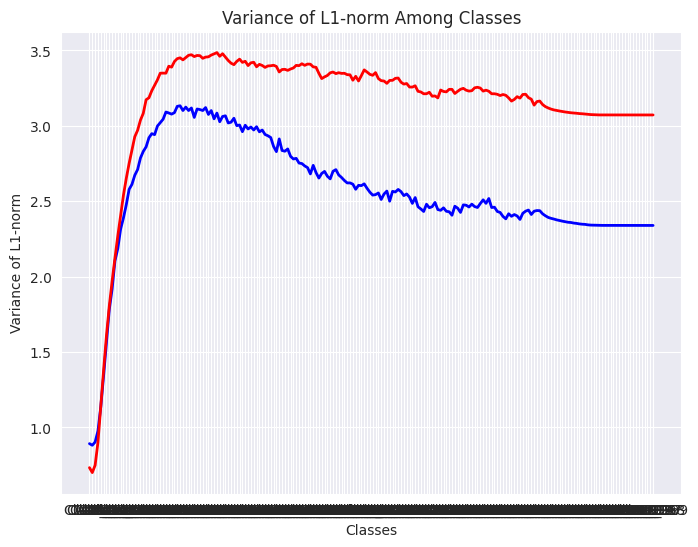

In [39]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list1)), variance_list1, color='blue', linestyle='-', linewidth=2)
plt.plot(range(len(variance_list)), variance_list, color='red', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list1)), [f'Class_{i}' for i in range(len(variance_list1))])
plt.grid(True)
plt.show()